In [1]:
import re
import glob
import pywt

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV


import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

/Users/user/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Concatenate all the files

In [2]:
# get path to all files
path = 'data/spectra/simulated_data/'

files = sorted(glob.glob(path + 'model_parameters_data*.txt'), key=lambda x: int(re.search(r'\d+', x).group()))

output_path = 'data/params/'
# write_data = open(output_path + 'model_parameters_data_all_5K.txt', 'w')

# # read in all files
# for file in files:
#     with open(file, 'r') as f:
#         # skip the first 10 lines in each file
#         for i in range(10):
#             f.readline()
#         # read in the data from each file
#         data = f.readlines()
#         # write the data to the output file in the same order as the files
#         for i in range(len(data)):
#             write_data.write(data[i])

# write_data.close()  

In [3]:
# # get the params data
# df_param = pd.DataFrame()
# for file in files:
#     # get the parameters used
#     df_param = df_param.append(pd.read_csv(file, skiprows=1, nrows=6, header=None, sep=' ', names=['A', 'B', 'C', 'D']))
#     # save the dataframe to a csv file
# df_param.to_csv(output_path + 'model_parameters_data_5K.csv', index=False)

#### Load the files 

In [4]:
df_data = pd.read_csv(output_path + 'model_parameters_data_all_5K.txt', sep=' ', header=None) # all data dataframe
df_data.head()

0    1
0  220.23500  0.0
1  220.23501  0.0
2  220.23502  0.0
3  220.23503  0.0
4  220.23504  0.0

In [5]:
df_data.shape

(282500000, 2)

In [6]:
df_param = pd.read_csv(output_path + 'model_parameters_data_5K.csv')
df_param.head()

A  B             C     D
0  tcmb  =  2.730000e+00     K
1  ntot  =  3.444610e+16  cm-2
2   tex  =  2.460550e+02     K
3  fwhm  =  3.258734e+00  km/s
4  vlsr  =  4.348123e+01  km/s

In [7]:
# drop the second and fourth column
df_param.drop(['B', 'D'], axis=1, inplace=True)

In [8]:
# transform the data to the right dataframe
df_param = df_param.assign(g = df_param.groupby('A').cumcount()).pivot(index='g', columns='A', values='C')

In [9]:
df_param.head(10)

A      fwhm          ntot      size  tcmb         tex        vlsr
g                                                                
0  3.258734  3.444610e+16  1.567994  2.73  246.054980   43.481234
1  6.247883  1.491641e+16  1.657387  2.73  295.048234 -101.490435
2  8.357213  1.641768e+16  0.351157  2.73  214.658336   49.825448
3  5.671066  1.470547e+17  0.664557  2.73  188.606010  -73.705679
4  3.953190  1.554346e+16  1.883757  2.73  169.547114  -31.028097
5  3.046011  6.435193e+16  1.051927  2.73  252.439724   51.988873
6  7.982460  1.243196e+17  1.356914  2.73  357.825152  -22.888178
7  5.811698  1.448788e+16  0.854588  2.73  399.338537  -14.444369
8  6.317850  1.094711e+17  0.862763  2.73  379.544134   91.373912
9  4.980673  4.185926e+17  2.214305  2.73  258.183158  -84.696529

In [10]:
df_param.columns

Index(['fwhm', 'ntot', 'size', 'tcmb', 'tex', 'vlsr'], dtype='object', name='A')

In [11]:
columns = ['Frequency', 'Intensity']
df_data.columns = columns
df_data.shape

(282500000, 2)

In [12]:
df_data.head()

Frequency  Intensity
0  220.23500        0.0
1  220.23501        0.0
2  220.23502        0.0
3  220.23503        0.0
4  220.23504        0.0

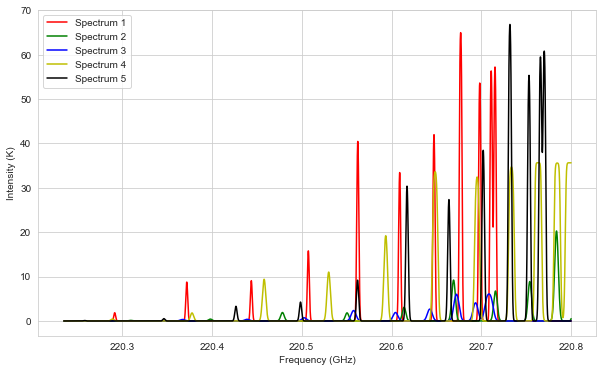

In [13]:
freq_sig = np.array(np.array_split(df_data['Frequency'], len(files)))
signal = np.array(np.array_split(df_data['Intensity'], len(files)))

# plot the signal in one plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.plot(freq_sig[0],  signal[0], color='r', label='Spectrum 1')
plt.plot(freq_sig[1], signal[1], color='g', label='Spectrum 2')
plt.plot(freq_sig[2], signal[2], color='b', label='Spectrum 3')
plt.plot(freq_sig[3], signal[3], color='y', label='Spectrum 4')
plt.plot(freq_sig[4], signal[4], color='k', label='Spectrum 5')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (K)")
plt.legend()
plt.show()

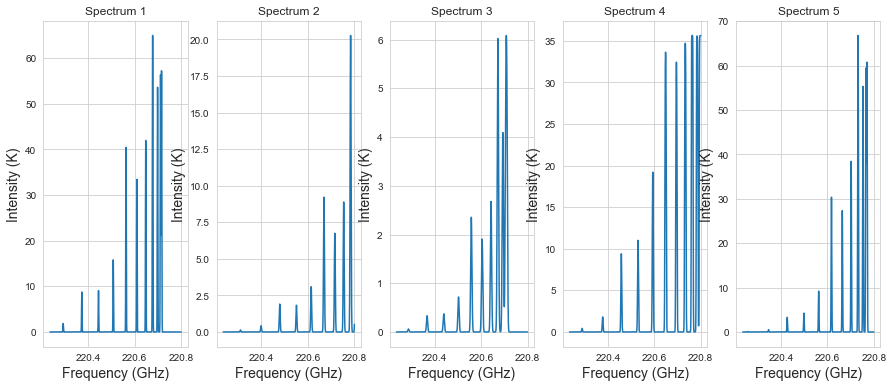

In [14]:
# plot the data in separate plots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
sns.set_style("whitegrid")
for i, ax in enumerate(axes.ravel(), start=1):
    ax.plot(freq_sig[i-1], signal[i-1], label='Spectrum {}'.format(i))
    ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
    ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
    ax.set_title("Spectrum {}".format(i))
    
# plt.savefig('../spectra/simulated_data/spectrum_plots.png')

In [15]:
# print(pywt.wavelist())

### Feature Extraction - Wavelet Decomposition

In [16]:
#create a  feature vector array for each spectrum 
feature_vector = np.zeros((len(signal), int(df_data.shape[0]/len(files))))
detail_coeffs = np.zeros((len(signal), 1766))
approx_coeffs = np.zeros((len(signal), 1766))
level = 5
wname = 'db35'
def decompose_signal_dwt(_signal, wavelet=wname, mode='per', level=level):
    """
    Performs wavelet denoising on the given signal.
    """
    # loop throuh all the spectra 
    for spectra_index in range(len(_signal)):
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        coeffs = pywt.wavedec(_signal[spectra_index], wavelet=wavelet, mode=mode, level=level)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        detail_coeffs[spectra_index, :] = coeff_arr[coeff_slices[1]['d']] # 4th level detail coeffs 
        # get the approximation coeffs
        approx_coeffs[spectra_index, :] = coeffs[0] # 4th level approximation coeffs
        
        reconstructed_signal = pywt.waverec(coeffs, wavelet=wavelet, mode=mode)
        feature_vector[spectra_index, :] = coeff_arr[:int(df_data.shape[0]/len(files))]
        # add the coeff_arr to the dataframe for each spectra
        # df_data['fv_dwt_{}'.format(wavelet)] = pd.Series(feature_vector.reshape(1, -1)[0], index=df_data.index) #TODO: find a way to optimize (or comment it out)
        
    return coeff_arr, coeff_slices

In [17]:
feature_vector.shape

(5000, 56500)

In [18]:
coeff_arr, coeff_slices = decompose_signal_dwt(signal)
df_data

Frequency  Intensity
0          220.23500        0.0
1          220.23501        0.0
2          220.23502        0.0
3          220.23503        0.0
4          220.23504        0.0
...              ...        ...
282499995  220.79995        0.0
282499996  220.79996        0.0
282499997  220.79997        0.0
282499998  220.79998        0.0
282499999  220.79999        0.0

[282500000 rows x 2 columns]

In [19]:
detail_coeffs.shape
detail_coeffs

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.06857437e-01,  2.98262615e-01, -2.21653974e-01, ...,
         2.35763682e-02,  3.57627735e-01,  6.14270855e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-4.51130331e+01,  4.09375933e+01, -2.85733099e+01, ...,
        -4.35051613e-01,  4.98587618e+01,  1.29194165e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## Wavelet Decomposition Plots

In [20]:
def decomposed_dwt_detail_coeffs_plots(_signal, wavelet=wname, level=level):
    """
    Plots of the detail coeffs of the signal.
    """
    # plot the reconstructed signal and the original signal in one plot
    for spectra_index in range(len(_signal)):                     
        # compute the maximum useful level of decomposition for each wavelet                        
        # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
        fig, axes = plt.subplots(nrows=1, ncols=level, dpi=400, sharey='none', sharex='all', figsize=(18, 5))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[i]['d']], label='Level {}'.format(i))
            ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
            ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
            ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 
            
        plt.show()

In [21]:
# decomposed_dwt_detail_coeffs_plots(signal) 

In [22]:
# TODO: find a way to plot the detail coefficients of the signal
def decomposed_dwt_approx_coeffs_plots(_signal, wavelet=wname, level=level):
    
    for spectra_index in range(len(_signal)):
        fig, axes = plt.subplots(nrows=1, ncols=level, figsize=(10, 6))
        sns.set_style("whitegrid")
        for i, ax in enumerate(axes.ravel(), start=1):
            ax.plot(coeff_arr[coeff_slices[1]['d']])
            ax.set_title("Spectrum {} approximation coeffiecients at level {} for {} ".format(spectra_index+1, i,  wavelet))
            
        plt.show()

In [23]:
# decomposed_dwt_approx_coeffs_plots(signal)

### Get Features and Labels

In [24]:
# fv = np.zeros((len(signal), int(df.shape[0]/len(files))))
# for spectra_index in range(len(signal)):
#     # get the level 3 detail coefficients
#     detail_coeffs = coeff_arr[coeff_slices[3]['d']]

# fv  = detail_coeffs
# labels =dff

In [25]:
# len(signal)

approx_coeffs.shape

(5000, 1766)

 #### Have a glimpse look at any of the signal and its generated detail and approximation coefficients 

In [26]:

# for spectra_index in range(len(signal)):                     
#         # compute the maximum useful level of decomposition for each wavelet                        
#         # max_level = pywt.dwt_max_level(len(_signal[spectra_index]), wavelet)
#         fig, axes = plt.subplots(nrows=1, ncols=10, sharey='none', sharex='all', figsize=(20, 7))
#         sns.set_style("whitegrid")
#         for i, ax in enumerate(axes.ravel(), start=1):
#             ax.plot(signal[spectra_index], label='Spectrum {}'.format(spectra_index))
#             # ax.set_xlabel("Frequency (GHz)", fontdict={'fontsize': 14})
#             # ax.set_ylabel("Intensity (K)", fontdict={'fontsize': 14})
#             # ax.set_title("Spectrum {} detail coeffiecients at level {} for {} ".format(spectra_index+1, i, wavelet)) 

#     # ax[0,1].plot(signal[spectra_index], label='original')
#     # ax[1,1].plot(approx_coeffs[spectra_index], label='spectrum {} approx coeff'.format(spectra_index+1))
#     # ax[2,1].plot(detail_coeffs[spectra_index], label='spectrum {} detail coeff'.format(spectra_index+1))
# plt.legend()
# plt.show()

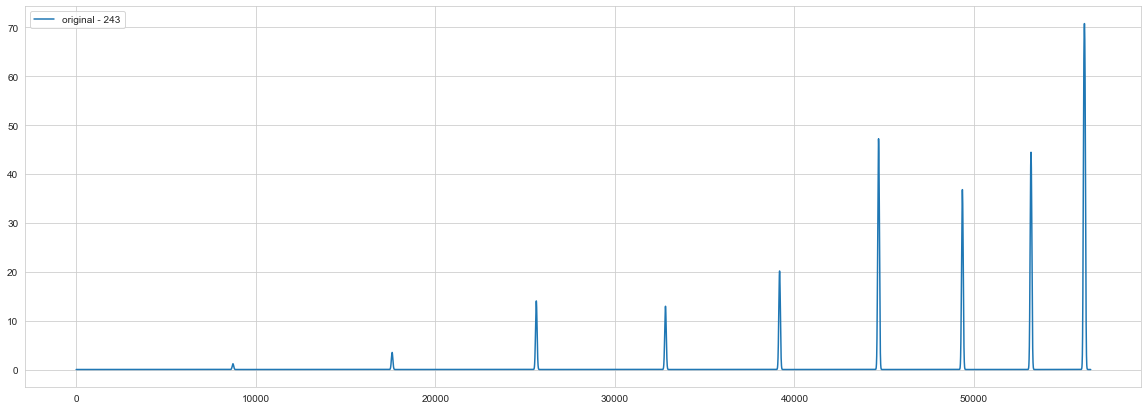

In [27]:
plt.figure(figsize=(20,7))
plt.plot(signal[243], label='original - 243')
plt.legend()
plt.savefig("data/5K_gen_files/original.png")
plt.show()

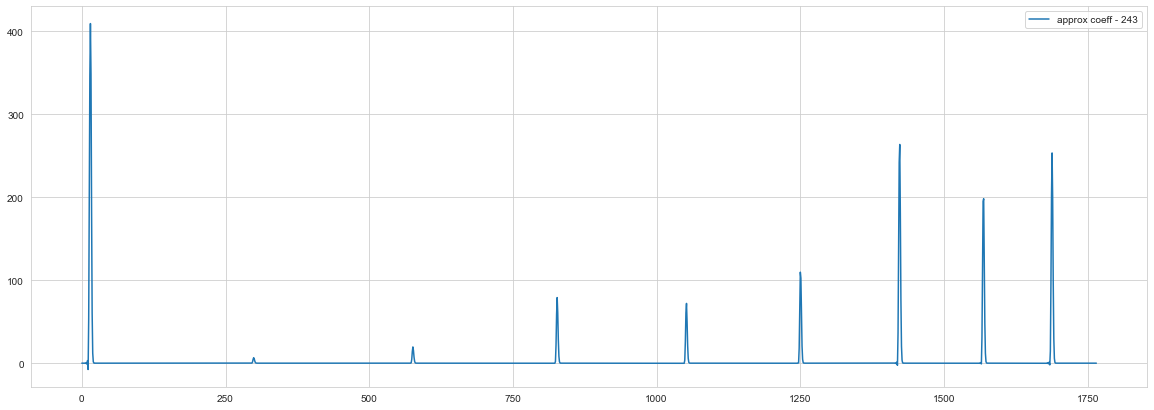

In [28]:
plt.figure(figsize=(20,7))
plt.plot(approx_coeffs[243], label='approx coeff - 243')
plt.legend()
plt.savefig("data/5K_gen_files/approx_level6.png")
plt.show()

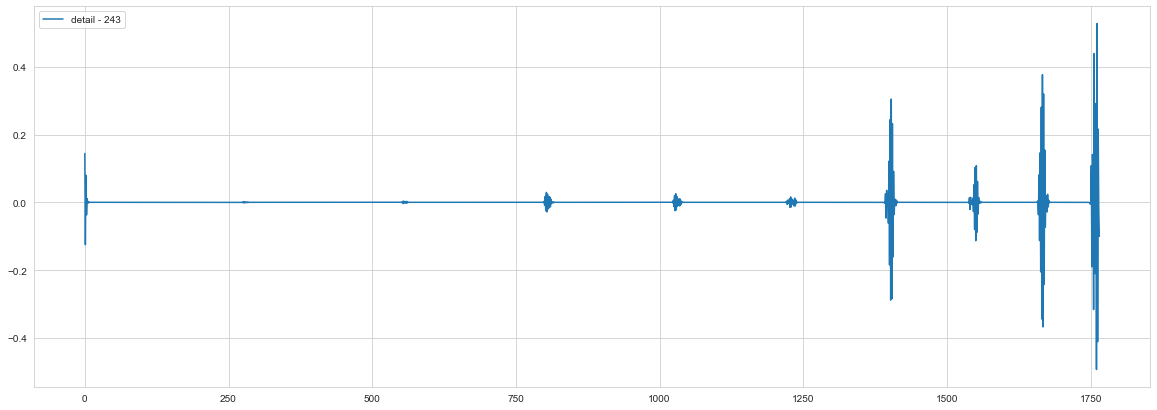

In [29]:
plt.figure(figsize=(20,7))
plt.plot(detail_coeffs[243], label='detail - 243')
plt.legend()
plt.savefig("data/5K_gen_files/detail_level6.png")
plt.show()

In [30]:
features = detail_coeffs
labels_ = df_param

print('feature_shape: ', features.shape, 'labels_shape: ', labels_.shape)


feature_shape:  (5000, 1766) labels_shape:  (5000, 6)


In [31]:
# drop the tcmb column
labels_.drop(columns=['tcmb'], inplace=True)

#### save the true params to a file

In [ ]:
# get the last 1500 data of the parameters from labels 
df_param = df_param.iloc[-1500:, :]
# save the vals to a csv file
df_param.to_csv("data/5K_gen_files/true_param_vals.csv")
df_param.head()


In [32]:
df = pd.DataFrame(approx_coeffs)
df.head()

0          1         2          3          4          5           6     \
0  0.000000   0.000000   0.00000   0.000000   0.000000   0.000000    0.000000   
1  0.035661   0.018146   0.00899   0.004338   0.002041   0.000923    0.000446   
2  0.000000   0.000000   0.00000   0.000000   0.000000   0.000000    0.000000   
3  9.745942  16.268178  26.54484  41.519140  61.652312  86.336752  113.516545   
4  0.000000   0.000000   0.00000   0.000000   0.000000   0.000000    0.000000   

         7             8             9     ...       1756       1757  \
0    0.000000  0.000000e+00  0.000000e+00  ...   0.000000   0.000000   
1    0.000143  1.319905e-04  1.273527e-04  ...   7.039184   4.687220   
2    0.000000  0.000000e+00  0.000000e+00  ...   0.000000   0.000000   
3  139.995956  1.625273e+02  1.792375e+02  ...  82.827524  59.409625   
4    0.000000  3.941644e-82 -3.051924e-74  ...   0.000000   0.000000   

        1758       1759       1760      1761      1762      1763      1764  \
0   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
1   3.036409   1.914049   1.174286  0.701274  0.407703  0.230770  0.127181   
2   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
3  40.336519  26.065703  16.164977  9.792188  6.083704  4.384906  4.356893   
4   0.000000   0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   

       1765  
0  0.000000  
1  0.068248  
2  0.000000  
3  6.016559  
4  0.000000  

[5 rows x 1766 columns]

In [33]:
df = pd.concat([df, labels_], axis=1)
df.head()

0          1         2          3          4          5           6  \
0  0.000000   0.000000   0.00000   0.000000   0.000000   0.000000    0.000000   
1  0.035661   0.018146   0.00899   0.004338   0.002041   0.000923    0.000446   
2  0.000000   0.000000   0.00000   0.000000   0.000000   0.000000    0.000000   
3  9.745942  16.268178  26.54484  41.519140  61.652312  86.336752  113.516545   
4  0.000000   0.000000   0.00000   0.000000   0.000000   0.000000    0.000000   

            7             8             9  ...      1761      1762      1763  \
0    0.000000  0.000000e+00  0.000000e+00  ...  0.000000  0.000000  0.000000   
1    0.000143  1.319905e-04  1.273527e-04  ...  0.701274  0.407703  0.230770   
2    0.000000  0.000000e+00  0.000000e+00  ...  0.000000  0.000000  0.000000   
3  139.995956  1.625273e+02  1.792375e+02  ...  9.792188  6.083704  4.384906   
4    0.000000  3.941644e-82 -3.051924e-74  ...  0.000000  0.000000  0.000000   

       1764      1765      fwhm          ntot      size         tex  \
0  0.000000  0.000000  3.258734  3.444610e+16  1.567994  246.054980   
1  0.127181  0.068248  6.247883  1.491641e+16  1.657387  295.048234   
2  0.000000  0.000000  8.357213  1.641768e+16  0.351157  214.658336   
3  4.356893  6.016559  5.671066  1.470547e+17  0.664557  188.606010   
4  0.000000  0.000000  3.953190  1.554346e+16  1.883757  169.547114   

         vlsr  
0   43.481234  
1 -101.490435  
2   49.825448  
3  -73.705679  
4  -31.028097  

[5 rows x 1771 columns]

In [34]:
# drop the values less than -60 in the vlsr column
# df = df.drop(df[df['vlsr'] < -60].index)
df = df[df['vlsr']>-60].reset_index(drop=True)
df.head()

0             1             2             3             4  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4 -3.227514e-19  9.233261e-19 -6.343836e-18  3.226965e-17 -8.077307e-17   

              5             6             7             8             9  ...  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
2  0.000000e+00  0.000000e+00  0.000000e+00  3.941644e-82 -3.051924e-74  ...   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
4 -9.002182e-17  1.842118e-15 -9.732361e-15  3.439310e-14 -9.274160e-14  ...   

           1761          1762          1763          1764          1765  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4 -1.005282e-21  4.912067e-21 -6.068151e-21 -2.834703e-20  1.462027e-19   

       fwhm          ntot      size         tex       vlsr  
0  3.258734  3.444610e+16  1.567994  246.054980  43.481234  
1  8.357213  1.641768e+16  0.351157  214.658336  49.825448  
2  3.953190  1.554346e+16  1.883757  169.547114 -31.028097  
3  3.046011  6.435193e+16  1.051927  252.439724  51.988873  
4  7.982460  1.243196e+17  1.356914  357.825152 -22.888178  

[5 rows x 1771 columns]

In [35]:
df.shape

(3677, 1771)

In [36]:
# get the last 1104 data of the parameters from labels 
df_param = df.iloc[-1104:, -5:]
# save the vals to a csv file
df_param.to_csv("data/5K_gen_files/true_param_vals_less.csv")
df_param.head()

fwhm          ntot      size         tex        vlsr
2573  5.955426  4.485307e+17  1.712827   18.919985   69.373749
2574  2.795046  1.092965e+17  2.135144  282.691227  -51.967895
2575  9.690123  2.801812e+16  2.102953  301.749129  105.038268
2576  8.207033  4.516519e+17  2.193458  371.135282   68.391472
2577  6.415884  4.880667e+16  1.639655  164.915336   13.812730

In [38]:
# convert the ntot column to log values 
df['ntot'] = np.log10(df['ntot'])
df.head()

0             1             2             3             4  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4 -3.227514e-19  9.233261e-19 -6.343836e-18  3.226965e-17 -8.077307e-17   

              5             6             7             8             9  ...  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
2  0.000000e+00  0.000000e+00  0.000000e+00  3.941644e-82 -3.051924e-74  ...   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
4 -9.002182e-17  1.842118e-15 -9.732361e-15  3.439310e-14 -9.274160e-14  ...   

           1761          1762          1763          1764          1765  \
0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4 -1.005282e-21  4.912067e-21 -6.068151e-21 -2.834703e-20  1.462027e-19   

       fwhm       ntot      size         tex       vlsr  
0  3.258734  16.537140  1.567994  246.054980  43.481234  
1  8.357213  16.215312  0.351157  214.658336  49.825448  
2  3.953190  16.191548  1.883757  169.547114 -31.028097  
3  3.046011  16.808562  1.051927  252.439724  51.988873  
4  7.982460  17.094540  1.356914  357.825152 -22.888178  

[5 rows x 1771 columns]

In [39]:
X = df.iloc[:, :1766]
y = df.iloc[:, -5:]

In [40]:
X

0             1             2             3             4     \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4    -3.227514e-19  9.233261e-19 -6.343836e-18  3.226965e-17 -8.077307e-17   
...            ...           ...           ...           ...           ...   
3672  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3673 -7.093648e-50  8.289847e-48 -9.646999e-47 -3.497419e-44  2.877721e-42   
3674 -1.447754e-09  4.151564e-09 -2.116781e-08  8.394050e-08 -9.043631e-08   
3675  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3676  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              5             6             7             8             9     \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     0.000000e+00  0.000000e+00  0.000000e+00  3.941644e-82 -3.051924e-74   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4    -9.002182e-17  1.842118e-15 -9.732361e-15  3.439310e-14 -9.274160e-14   
...            ...           ...           ...           ...           ...   
3672  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3673 -5.406395e-41 -1.429260e-39  5.614056e-38 -3.758221e-37 -5.630026e-36   
3674 -1.136473e-06  8.914730e-06 -3.882178e-05  1.220176e-04 -2.941252e-04   
3675  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3676  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

      ...          1756          1757          1758          1759  \
0     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3     ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4     ...  4.036744e-25 -1.030426e-24 -9.755827e-24  6.835030e-23   
...   ...           ...           ...           ...           ...   
3672  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3673  ...  0.000000e+00  0.000000e+00 -6.629406e-84  1.705127e-75   
3674  ...  1.490516e-15 -4.958158e-15 -3.094682e-14  2.623396e-13   
3675  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3676  ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              1760          1761          1762          1763          1764  \
0     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
1     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4    -6.218807e-23 -1.005282e-21  4.912067e-21 -6.068151e-21 -2.834703e-20   
...            ...           ...           ...           ...           ...   
3672  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3673 -1.249126e-69  4.330843e-65 -5.087730e-61 -2.846824e-58  1.171460e-54   
3674 -3.831458e-13 -3.268854e-12  1.868402e-11 -2.995663e-11 -8.397600e-11   
3675  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
3676  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

              1765  
0     0.000000e+00  
1     0.000000e+00  
2     0.000000e+00  
3     0.000000e+00  
4     1.462027e-19  
...            ...  
3672  0.000000e+00  
3673 -1.087552e-52  
3674  5.480970e-10  
3675  0.000000e+00  
3676  0.000000e+00  

[3677 rows x 1766 columns]

In [41]:
y

fwhm       ntot      size         tex        vlsr
0     3.258734  16.537140  1.567994  246.054980   43.481234
1     8.357213  16.215312  0.351157  214.658336   49.825448
2     3.953190  16.191548  1.883757  169.547114  -31.028097
3     3.046011  16.808562  1.051927  252.439724   51.988873
4     7.982460  17.094540  1.356914  357.825152  -22.888178
...        ...        ...       ...         ...         ...
3672  7.488187  16.935586  0.378228  382.205837   45.696647
3673  9.373324  16.029790  1.010992  252.187605   78.019352
3674  9.211432  17.607928  2.356792  108.855293  126.633894
3675  3.104411  16.406196  1.645601  374.525593   47.281143
3676  3.240731  16.300573  2.483829   94.102599   74.657562

[3677 rows x 5 columns]

#### split the data into the training and test set

In [42]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    shuffle=False,
    random_state=42
    )

print('X_train shape: ',  X_train.shape, '\n',
    'y_train shape: ', y_train.shape, '\n',
    'X_test shape: ', X_test.shape, '\n',
    'y_test shape: ', y_test.shape)

X_train shape:  (2573, 1766) 
 y_train shape:  (2573, 5) 
 X_test shape:  (1104, 1766) 
 y_test shape:  (1104, 5)


## 1. Multioutput Regressor - RF

In [43]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

# tuned model to use instantly
regr_multirf = MultiOutputRegressor(
    estimator=RandomForestRegressor(
        bootstrap='False',
        max_depth=90,
        max_features='log2',
        max_samples=0.8999999999999999,
        n_estimators=700,
        n_jobs=-1,
        random_state=7,
        verbose=2
))

# # from tuned model
# regr_multirf = MultiOutputRegressor(
#     estimator=RandomForestRegressor(
#        n_estimators=800, 
#        min_samples_split=2,
#        min_samples_leaf=1,
#        max_features='auto', 
#        max_depth=130,
#        bootstrap=True,
#        verbose=42
#     )
# )


# multioutput regressor+
regr_multirf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 4 of 700
building tree 6 of 700
building tree 5 of 700
building tree 7 of 700
building tree 2 of 700
building tree 8 of 700
building tree 3 of 700
building tree 1 of 700
building tree 11 of 700
building tree 10 of 700
building tree 9 of 700
building tree 15 of 700
building tree 13 of 700
building tree 12 of 700
building tree 14 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 18 of 700
building tree 20 of 700
building tree 21 of 700
building tree 22 of 700
building tree 25 of 700
building tree 23 of 700
building tree 24 of 700
building tree 26 of 700
building tree 27 of 700
building tree 28 of 700
building tree 29 of 700
building tree 33 of 700building tree 31 of 700

building tree 32 of 700
building tree 30 of 700
building tree 34 of 700
building tree 35 of 700
building tree 36 of 700
building tree 37 of 700


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s


building tree 38 of 700
building tree 40 of 700
building tree 39 of 700
building tree 41 of 700
building tree 44 of 700
building tree 45 of 700
building tree 42 of 700
building tree 43 of 700
building tree 46 of 700
building tree 47 of 700
building tree 48 of 700
building tree 49 of 700
building tree 50 of 700
building tree 51 of 700
building tree 53 of 700
building tree 52 of 700
building tree 55 of 700building tree 54 of 700

building tree 58 of 700
building tree 57 of 700
building tree 56 of 700
building tree 59 of 700
building tree 61 of 700
building tree 60 of 700
building tree 62 of 700
building tree 63 of 700
building tree 65 of 700
building tree 66 of 700
building tree 67 of 700
building tree 64 of 700
building tree 68 of 700
building tree 77 of 700
building tree 73 of 700
building tree 75 of 700
building tree 71 of 700
building tree 69 of 700
building tree 79 of 700
building tree 78 of 700
building tree 74 of 700
building tree 72 of 700
building tree 76 of 700
building tree 80

[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    9.9s


building tree 384 of 700
building tree 402 of 700
building tree 398 of 700
building tree 388 of 700
building tree 406 of 700
building tree 395 of 700
building tree 409 of 700
building tree 403 of 700
building tree 392 of 700
building tree 399 of 700
building tree 410 of 700
building tree 396 of 700
building tree 407 of 700
building tree 400 of 700
building tree 404 of 700
building tree 411 of 700
building tree 408 of 700
building tree 413 of 700
building tree 417 of 700
building tree 421 of 700
building tree 425 of 700
building tree 429 of 700
building tree 433 of 700
building tree 437 of 700
building tree 412 of 700
building tree 414 of 700
building tree 422 of 700
building tree 418 of 700
building tree 426 of 700
building tree 430 of 700
building tree 415 of 700
building tree 423 of 700
building tree 419 of 700
building tree 434 of 700
building tree 438 of 700
building tree 441 of 700
building tree 427 of 700
building tree 416 of 700
building tree 431 of 700
building tree 420 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 4 of 700building tree 7 of 700
building tree 1 of 700
building tree 5 of 700building tree 6 of 700


building tree 3 of 700
building tree 2 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 28 of 700
building tree 24 of 700
building tree 30 of 700
building tree 26 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 39 of 700
building tree 37 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 34 of 700
building tree 48 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 56 of 700
building tree 72 of 700
building tree 64 of 700
building tree 60 of 700
building tree 68 of 700
building tree 76 of 700
building tree 80 of 700
building tree 81 of 700
building tree 93 of 700
building tree 85 of 700
building tree 89 of 700
building tree 101 of 700
building tree 97 of 700
building tree 105 of 700
building tree 109 of 700
building tree 82 of 700
building tree 98 of 700
building tree 90 of 700
building tree 86 of 700
building tree 102 of 700
building tree 94 of 700
building tree 106 of 700
building tree 83 of 700
building tree 110 of 700
building tree 99 of 700
building tree 95 of 700
building tree 91 of 700
building tree 103 of 700
building tree 87 of 700
building tree 84 of 700
building tree 111 of 700
building tree 107 of 700
building tree 100 of 700
building tree 96 of 700
building tree 104 of 700
building tree 88 of 700
building tree 92 of 700
building tree 108 of 700
building tree 112 of 700
building tree 113 of 700
building tree 117 of 700
b

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.0s


building tree 561 of 700
building tree 536 of 700
building tree 544 of 700
building tree 548 of 700
building tree 558 of 700
building tree 551 of 700
building tree 555 of 700
building tree 540 of 700
building tree 562 of 700
building tree 565 of 700
building tree 569 of 700
building tree 559 of 700
building tree 552 of 700
building tree 556 of 700
building tree 573 of 700
building tree 577 of 700
building tree 563 of 700
building tree 560 of 700
building tree 581 of 700
building tree 574 of 700
building tree 566 of 700
building tree 570 of 700
building tree 564 of 700
building tree 585 of 700
building tree 578 of 700
building tree 567 of 700
building tree 589 of 700
building tree 571 of 700
building tree 575 of 700
building tree 586 of 700
building tree 582 of 700
building tree 579 of 700
building tree 593 of 700
building tree 590 of 700
building tree 568 of 700
building tree 572 of 700
building tree 576 of 700
building tree 583 of 700
building tree 580 of 700
building tree 587 of 700


[Parallel(n_jobs=-1)]: Done 685 out of 700 | elapsed:    4.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 1 of 700building tree 5 of 700

building tree 2 of 700
building tree 6 of 700
building tree 3 of 700
building tree 7 of 700
building tree 4 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 22 of 700
building tree 18 of 700
building tree 20 of 700
building tree 24 of 700
building tree 28 of 700
building tree 26 of 700
building tree 30 of 700
building tree 32 of 700
building tree 33 of 700
building tree 37 of 700
building tree 35 of 700
building tree 43 of 700
building tree 41 of 700
building tree 39 of 700
building tree 45 of 700
building tree 47 of 700
building tree 34 of 700
building tree 40 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s


building tree 50 of 700
building tree 58 of 700
building tree 74 of 700
building tree 62 of 700
building tree 70 of 700
building tree 66 of 700
building tree 78 of 700
building tree 54 of 700
building tree 51 of 700
building tree 63 of 700
building tree 71 of 700
building tree 55 of 700
building tree 59 of 700
building tree 79 of 700
building tree 67 of 700
building tree 75 of 700
building tree 52 of 700
building tree 64 of 700
building tree 60 of 700
building tree 76 of 700
building tree 56 of 700
building tree 72 of 700
building tree 80 of 700
building tree 68 of 700
building tree 81 of 700
building tree 85 of 700
building tree 89 of 700
building tree 82 of 700
building tree 86 of 700
building tree 93 of 700
building tree 90 of 700
building tree 101 of 700
building tree 87 of 700
building tree 94 of 700
building tree 83 of 700
building tree 91 of 700
building tree 105 of 700
building tree 97 of 700
building tree 109 of 700
building tree 102 of 700
building tree 95 of 700
building tre

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.5s


building tree 543 of 700
building tree 546 of 700
building tree 550 of 700
building tree 532 of 700
building tree 539 of 700
building tree 554 of 700
building tree 536 of 700
building tree 544 of 700
building tree 558 of 700
building tree 547 of 700
building tree 551 of 700
building tree 540 of 700
building tree 561 of 700
building tree 555 of 700
building tree 552 of 700
building tree 548 of 700
building tree 565 of 700
building tree 559 of 700
building tree 569 of 700
building tree 556 of 700
building tree 562 of 700
building tree 560 of 700
building tree 573 of 700
building tree 577 of 700
building tree 570 of 700
building tree 566 of 700
building tree 581 of 700
building tree 574 of 700
building tree 563 of 700
building tree 585 of 700
building tree 589 of 700
building tree 571 of 700
building tree 567 of 700
building tree 582 of 700
building tree 578 of 700
building tree 564 of 700
building tree 575 of 700
building tree 586 of 700
building tree 568 of 700
building tree 579 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 8 of 700
building tree 1 of 700
building tree 2 of 700
building tree 3 of 700
building tree 4 of 700
building tree 5 of 700
building tree 6 of 700
building tree 7 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 15 of 700
building tree 14 of 700
building tree 16 of 700
building tree 17 of 700
building tree 19 of 700
building tree 21 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 31 of 700
building tree 20 of 700
building tree 30 of 700
building tree 26 of 700
building tree 18 of 700
building tree 22 of 700
building tree 28 of 700
building tree 24 of 700
building tree 32 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 45 of 700
building tree 47 of 700
building tree 36 of 700
building tree 34 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 81 of 700
building tree 85 of 700
building tree 82 of 700
building tree 86 of 700
building tree 89 of 700
building tree 83 of 700
building tree 87 of 700
building tree 97 of 700building tree 101 of 700

building tree 109 of 700
building tree 93 of 700
building tree 105 of 700
building tree 90 of 700
building tree 110 of 700
building tree 94 of 700
building tree 98 of 700
building tree 106 of 700
building tree 102 of 700
building tree 91 of 700
building tree 99 of 700
building tree 111 of 700
building tree 107 of 700
building tree 88 of 700
building tree 84 of 700
building tree 103 of 700
building tree 95 of 700
building tree 92 of 700
building tree 108 of 700
building tree 100 of 700
building tree 112 of 700
building tree 96 of 700
building tree 104 of 700
building tree 113 of 700
building tree 121 of 700
building tree 117 of 700
building tree 125 of 700
building tree 129 of 700
building tree 133 of 700
building tree 137 of 700
building tree 141 of 700
building tree 114 o

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.6s


building tree 535 of 700
building tree 538 of 700
building tree 524 of 700
building tree 531 of 700
building tree 528 of 700
building tree 545 of 700
building tree 542 of 700
building tree 546 of 700
building tree 532 of 700
building tree 549 of 700
building tree 553 of 700
building tree 539 of 700
building tree 536 of 700
building tree 543 of 700
building tree 557 of 700
building tree 540 of 700
building tree 547 of 700
building tree 550 of 700
building tree 561 of 700
building tree 544 of 700
building tree 565 of 700
building tree 554 of 700
building tree 558 of 700
building tree 551 of 700
building tree 569 of 700
building tree 548 of 700
building tree 559 of 700
building tree 566 of 700
building tree 562 of 700
building tree 555 of 700
building tree 552 of 700
building tree 573 of 700
building tree 577 of 700
building tree 570 of 700
building tree 563 of 700
building tree 556 of 700
building tree 567 of 700
building tree 560 of 700
building tree 574 of 700
building tree 581 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


building tree 2 of 700building tree 1 of 700
building tree 3 of 700
building tree 6 of 700
building tree 5 of 700

building tree 4 of 700
building tree 7 of 700
building tree 8 of 700
building tree 9 of 700
building tree 10 of 700
building tree 11 of 700
building tree 12 of 700
building tree 13 of 700
building tree 14 of 700
building tree 15 of 700
building tree 17 of 700
building tree 16 of 700
building tree 21 of 700
building tree 19 of 700
building tree 23 of 700
building tree 25 of 700
building tree 27 of 700
building tree 29 of 700
building tree 18 of 700
building tree 20 of 700
building tree 22 of 700
building tree 26 of 700
building tree 31 of 700
building tree 30 of 700
building tree 28 of 700
building tree 24 of 700
building tree 33 of 700
building tree 35 of 700
building tree 37 of 700
building tree 39 of 700
building tree 41 of 700
building tree 43 of 700
building tree 32 of 700
building tree 45 of 700
building tree 34 of 700
building tree 44 of 700
building tree 42 of 700
b

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


building tree 98 of 700
building tree 109 of 700
building tree 102 of 700
building tree 106 of 700
building tree 95 of 700
building tree 83 of 700
building tree 91 of 700
building tree 99 of 700
building tree 87 of 700
building tree 103 of 700
building tree 110 of 700
building tree 84 of 700
building tree 96 of 700
building tree 92 of 700
building tree 88 of 700
building tree 100 of 700
building tree 107 of 700
building tree 104 of 700
building tree 111 of 700
building tree 113 of 700
building tree 108 of 700
building tree 114 of 700
building tree 112 of 700
building tree 115 of 700
building tree 116 of 700
building tree 117 of 700
building tree 121 of 700
building tree 125 of 700
building tree 129 of 700
building tree 133 of 700
building tree 137 of 700
building tree 118 of 700
building tree 130 of 700
building tree 126 of 700
building tree 122 of 700
building tree 134 of 700
building tree 138 of 700
building tree 141 of 700
building tree 119 of 700
building tree 127 of 700
building t

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    2.3s


building tree 549 of 700
building tree 535 of 700
building tree 539 of 700
building tree 532 of 700
building tree 542 of 700
building tree 553 of 700
building tree 557 of 700
building tree 546 of 700
building tree 536 of 700
building tree 540 of 700
building tree 550 of 700
building tree 554 of 700
building tree 543 of 700
building tree 547 of 700
building tree 555 of 700
building tree 551 of 700
building tree 558 of 700
building tree 544 of 700
building tree 548 of 700
building tree 556 of 700
building tree 552 of 700
building tree 559 of 700
building tree 561 of 700
building tree 565 of 700
building tree 569 of 700
building tree 573 of 700
building tree 560 of 700
building tree 577 of 700
building tree 581 of 700
building tree 562 of 700
building tree 566 of 700
building tree 570 of 700
building tree 574 of 700
building tree 563 of 700
building tree 571 of 700
building tree 567 of 700
building tree 578 of 700
building tree 582 of 700
building tree 575 of 700
building tree 564 of 700


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:    3.0s finished


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap='False',
                                                     max_depth=90,
                                                     max_features='log2',
                                                     max_samples=0.8999999999999999,
                                                     n_estimators=700,
                                                     n_jobs=-1, random_state=7,
                                                     verbose=2))

In [44]:
#  predict on the new test data
y_multirf_pred = regr_multirf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

In [45]:
regr_multirf.score(X_test, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 700 out of 700 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(

0.7386782627450821

### save the predicted parameters to a csv file 

In [46]:
param_df_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm_rf_pred', 'ntot_rf_pred', 'size_rf_pred', 'tex_rf_pred', 'vlsr_rf_pred'], index=X_test.index)
param_df_rf.head()

fwhm_rf_pred  ntot_rf_pred  size_rf_pred  tex_rf_pred  vlsr_rf_pred
2573      6.054450     17.042894      1.834090    35.528404     69.691332
2574      2.653644     17.079236      1.841747   241.808155    -51.147603
2575      9.221223     16.844434      0.814975   305.760226    104.945917
2576      8.278044     17.595892      2.021449   232.114767     68.572424
2577      6.348445     17.084526      1.582818   188.744662     14.150124

In [47]:
# convert back the log to linear values 
param_df_rf['ntot_rf_pred'] = np.array(10**param_df_rf['ntot_rf_pred'])

In [48]:
param_df_rf.to_csv('data/5K_gen_files/predicted_parameters_rf_less.csv', index=True)
param_df_rf.shape

(1104, 5)

In [49]:
pred_para = pd.read_csv('data/5K_gen_files/predicted_parameters_rf_less.csv')
true_para = pd.read_csv('data/5K_gen_files/true_param_vals_less.csv')

# add the predicted value to the true value dataframe as new columns separated by an empty column 
true_para = pd.concat([true_para,  pd.DataFrame(np.zeros(len(true_para))), pred_para], axis=1)
true_para.to_csv('data/5K_gen_files/true_param_vals_with_predicted_rf_less.csv')
true_para.head()

Unnamed: 0      fwhm          ntot      size         tex        vlsr    0  \
0        2573  5.955426  4.485307e+17  1.712827   18.919985   69.373749  0.0   
1        2574  2.795046  1.092965e+17  2.135144  282.691227  -51.967895  0.0   
2        2575  9.690123  2.801812e+16  2.102953  301.749129  105.038268  0.0   
3        2576  8.207033  4.516519e+17  2.193458  371.135282   68.391472  0.0   
4        2577  6.415884  4.880667e+16  1.639655  164.915336   13.812730  0.0   

   Unnamed: 0  fwhm_rf_pred  ntot_rf_pred  size_rf_pred  tex_rf_pred  \
0        2573      6.054450  1.103810e+17      1.834090    35.528404   
1        2574      2.653644  1.200152e+17      1.841747   241.808155   
2        2575      9.221223  6.989303e+16      0.814975   305.760226   
3        2576      8.278044  3.943594e+17      2.021449   232.114767   
4        2577      6.348445  1.214860e+17      1.582818   188.744662   

   vlsr_rf_pred  
0     69.691332  
1    -51.147603  
2    104.945917  
3     68.572424  
4     14.150124

#### Metrics

In [50]:
class RegressionMetrics:
    def __init__(self):
        self.metrics = {
            "mae": self._mean_absolute_error,
            "mse": self._mean_squared_error,
            "rmse": self._root_mean_squared_error,
            "mape": self._mean_absolute_percentage_error,
            "r2": self._r2_score,
            "msle": self._mean_squared_log_error,
            # "rmsle": self._root_mean_squared_logarithmic_error,
        }

    def get_metric(self, metric,  y_true, y_pred):
        if metric not in self.metrics:
            raise Exception("Metric not found")
        
        if metric == "mae":
            return self._mean_absolute_error(y_true, y_pred)
        if metric == "mse":
            return self._mean_squared_error(y_true, y_pred)
        if metric == "rmse":
            return self._root_mean_squared_error(y_true, y_pred)
        if metric == "mape":
            return self._mean_absolute_percentage_error(y_true, y_pred)
        if metric == "r2":
            return self._r2_score(y_true, y_pred)
        if metric == "msle":
            return self._mean_squared_log_error(y_true, y_pred)
        # if metric == "rmsle":
        #     return self._root_mean_squared_logarithmic_error(y_true, y_pred)
        
    @staticmethod
    def _mean_absolute_error(y_true, y_pred):
        return metrics.mean_absolute_error(y_true, y_pred)

    @staticmethod
    def _mean_squared_error(y_true, y_pred):
        return metrics.mean_squared_error(y_true, y_pred)

    def _root_mean_squared_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    def _mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    @staticmethod
    def _r2_score(y_true, y_pred):
        return metrics.r2_score(y_true, y_pred)
    
    def _mean_squared_log_error(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    
    # TODO: investigate in the case where it gives an error
    # def _root_mean_squared_logarithmic_error(self, y_true, y_pred):
    #     return np.sqrt(np.mean(np.square(np.log(y_pred + 1) - np.log(y_true + 1))))


In [51]:
# get the metricl for the multirf regressor
metrics_multirf = RegressionMetrics()
_metrics = ['mae', 'mse', 'rmse', 'mape', 'r2', 'msle']
for metric in _metrics:
    print("Multirf  {}: ".format(metric), metrics_multirf.get_metric(metric, y_test, y_multirf_pred))

Multirf  mae:  11.760818245706686
Multirf  mse:  964.7808630435748
Multirf  rmse:  31.060921799643594
Multirf  mape:  fwhm     9.412946
ntot     1.787228
size    38.486702
tex     42.876771
vlsr    18.216166
dtype: float64
Multirf  r2:  0.7386782627450821
Multirf  msle:  31.060921799643594


### Predicted vs True values plots

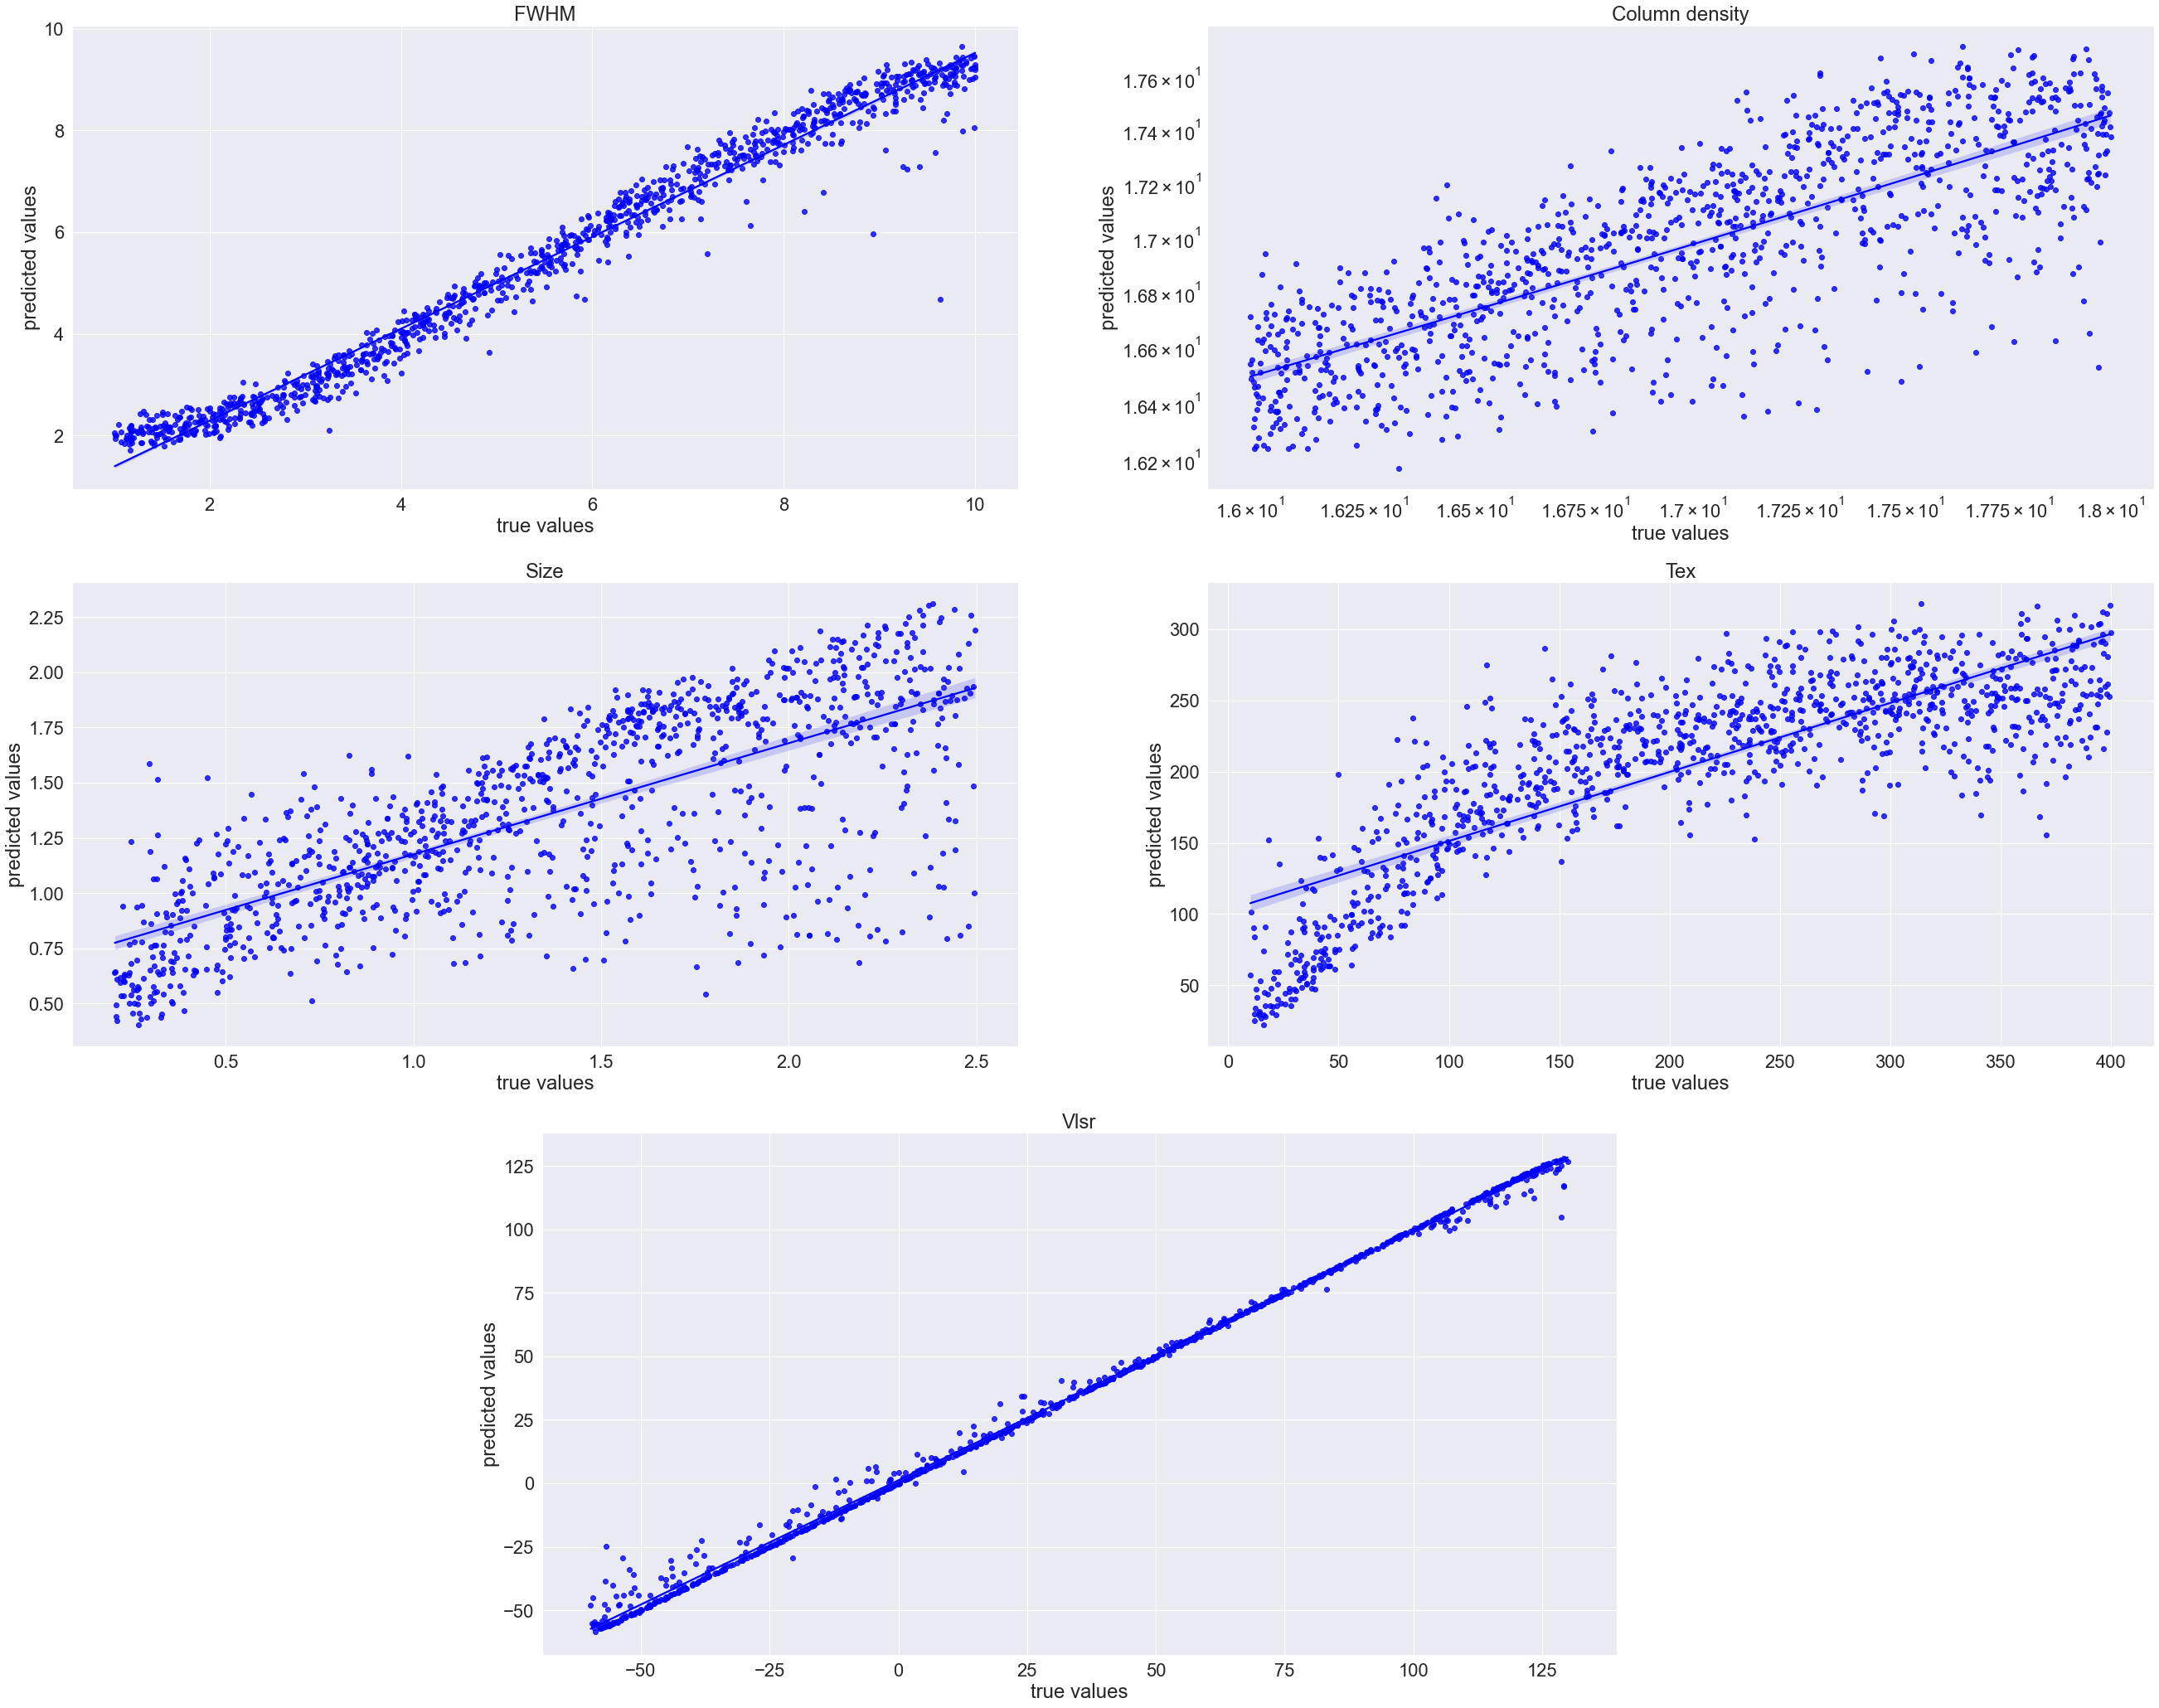

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_pred[:,0], color='blue', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_pred[:,1], color='blue', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_pred[:,2], color='blue', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_pred[:,3], color='blue', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_pred[:,4], color='blue', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/5K_gen_files/pred_true_5K_RF_less.png")
plt.show()

### 3D plots -  Columnn density, Excitation temperature and Size

In [54]:
pred_param_rf = pd.DataFrame(y_multirf_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_rf.head()

fwhm       ntot      size         tex        vlsr
0  6.054450  17.042894  1.834090   35.528404   69.691332
1  2.653644  17.079236  1.841747  241.808155  -51.147603
2  9.221223  16.844434  0.814975  305.760226  104.945917
3  8.278044  17.595892  2.021449  232.114767   68.572424
4  6.348445  17.084526  1.582818  188.744662   14.150124

### Residuals 3D plot -  Random Forest Regressor

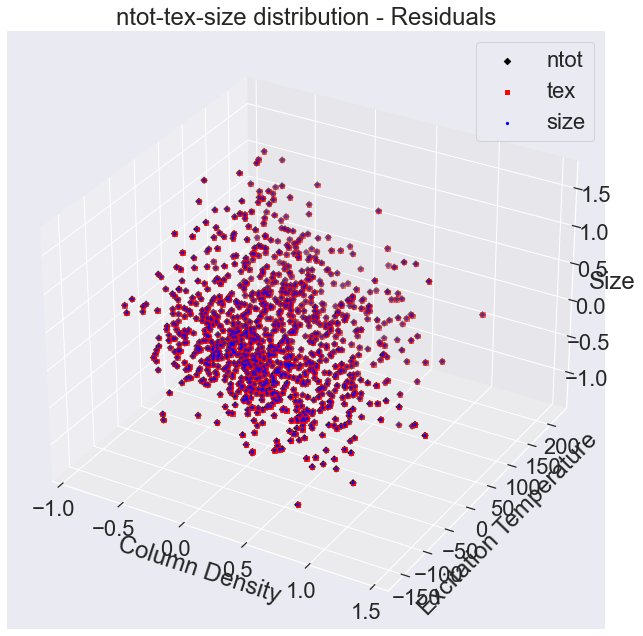

In [55]:
fig = plt.figure(figsize=(26, 11))
plt.setp(ax.get_xticklabels(), fontsize=12)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_rf = (y_test - y_multirf_pred)
# residuals
x1 = residuals_rf['ntot']
y1 = residuals_rf['tex']
z1 = residuals_rf['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

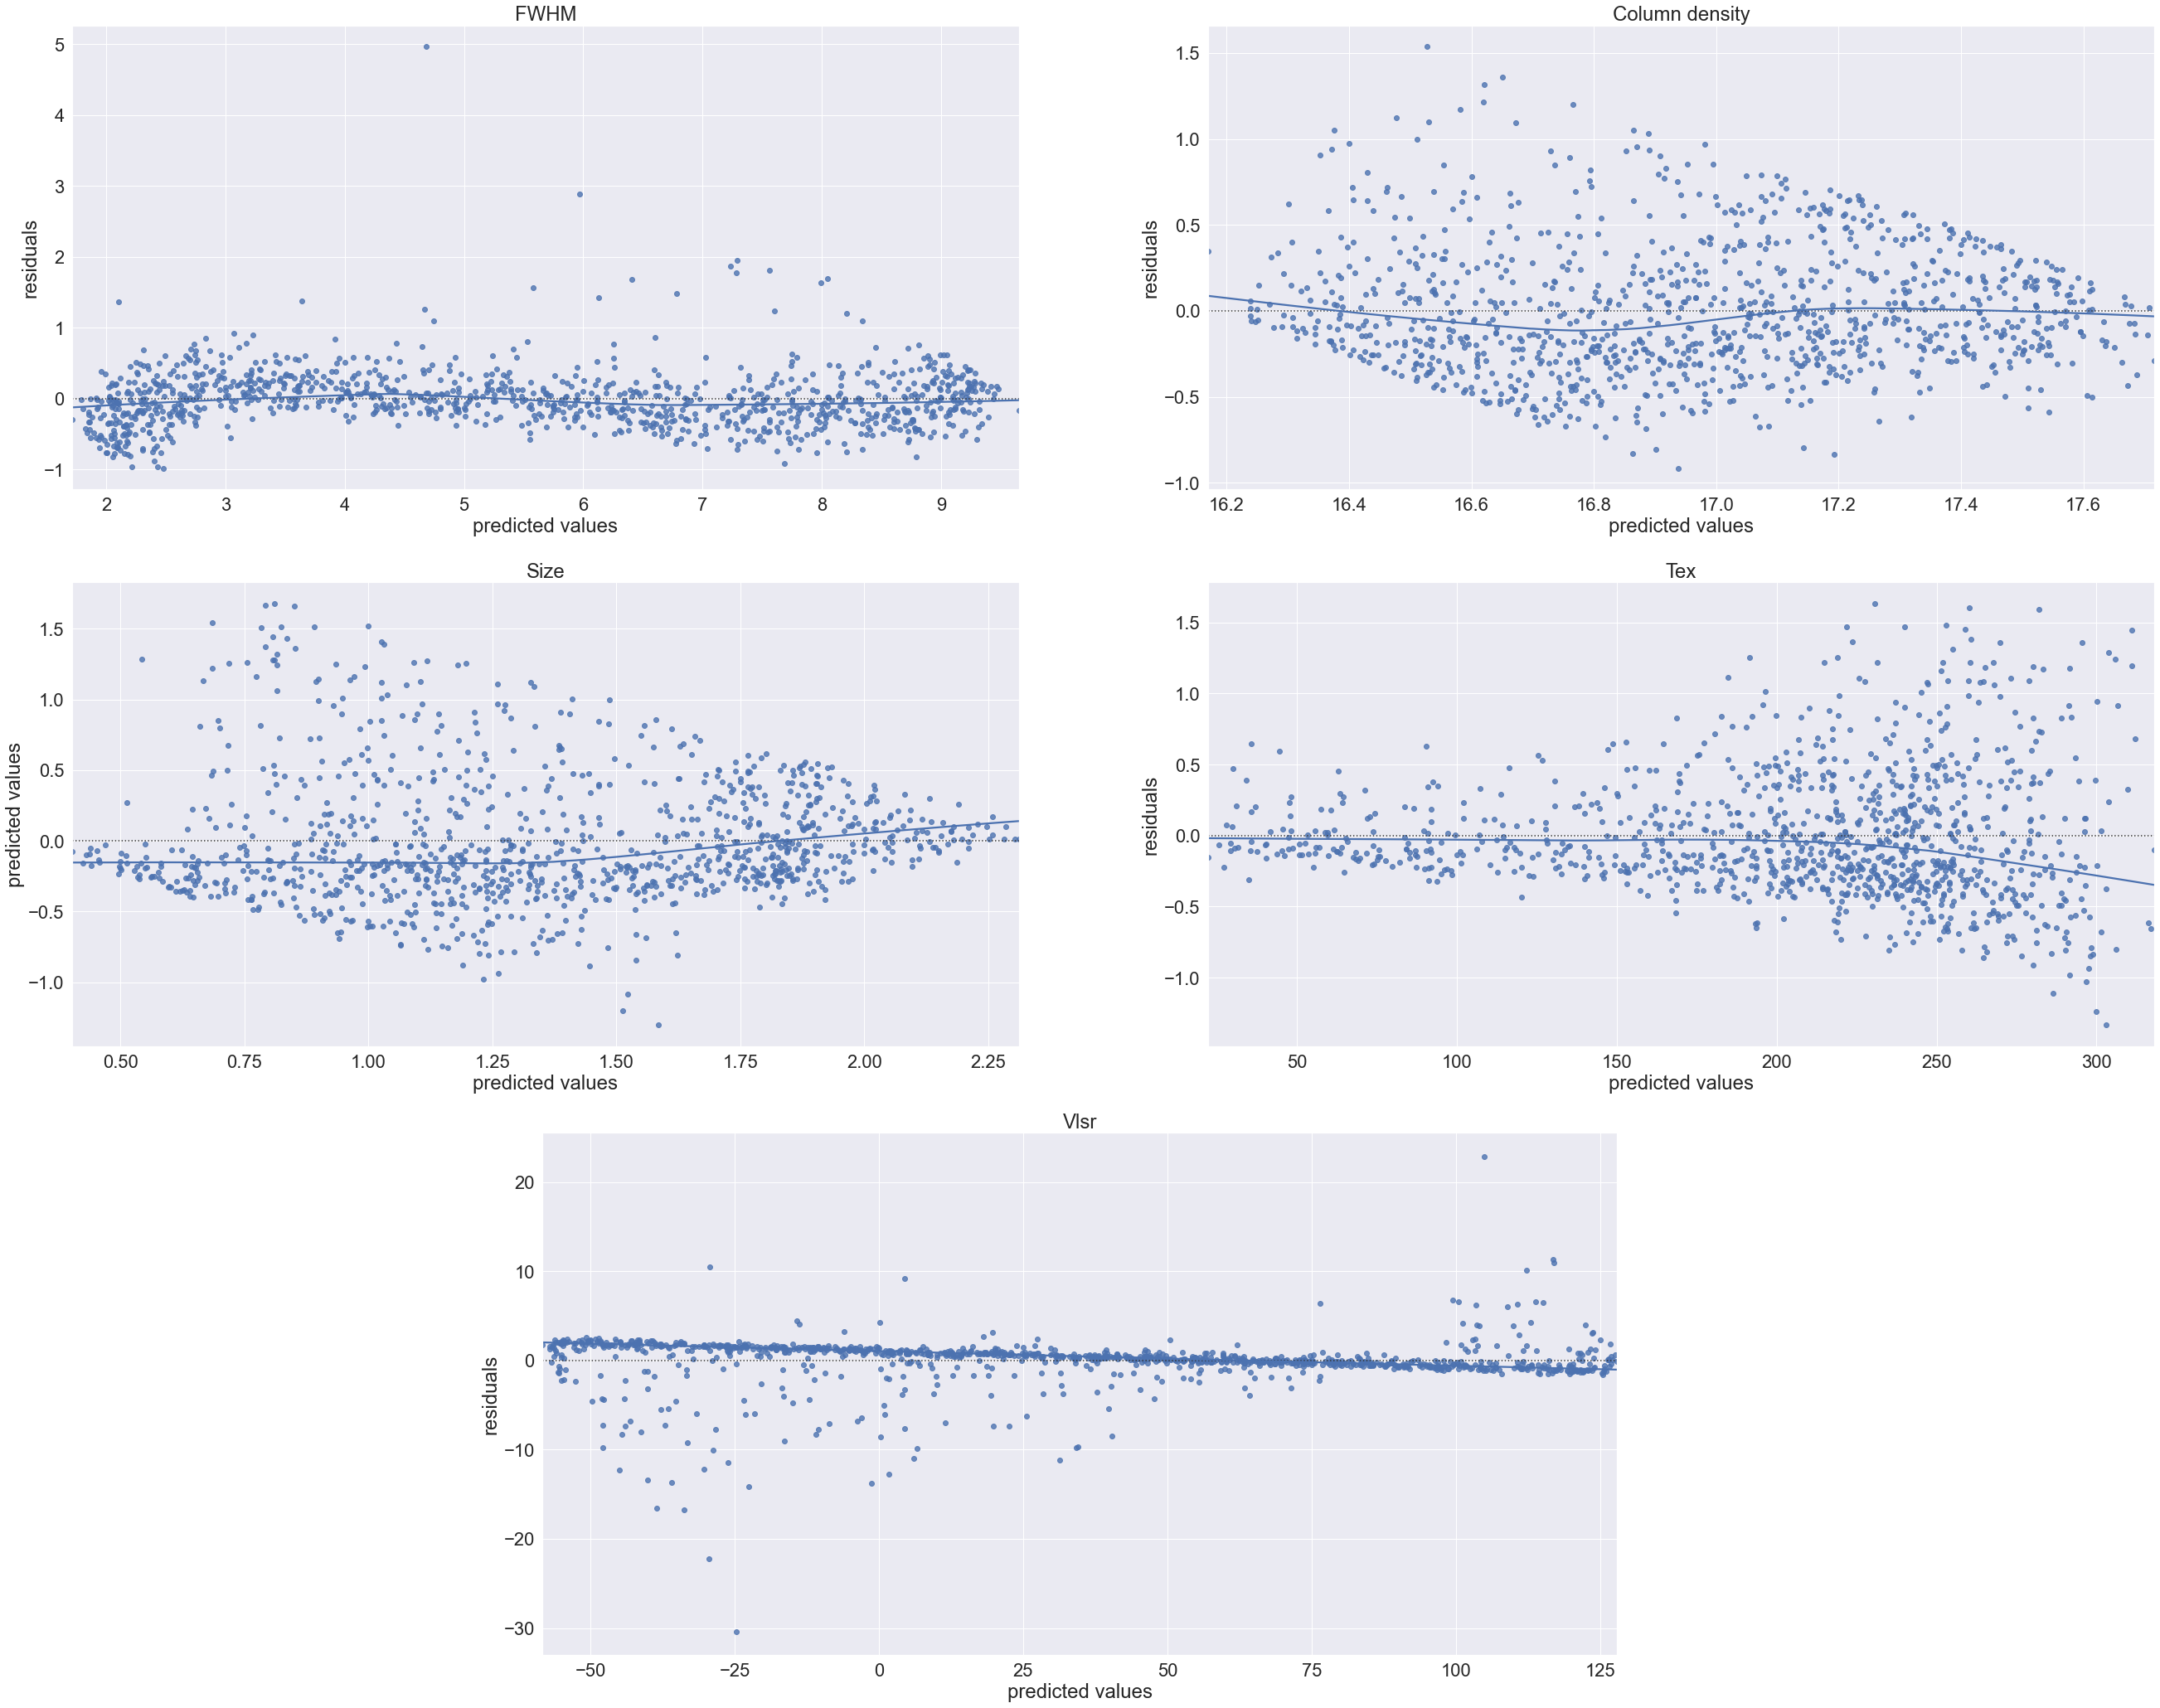

In [56]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multirf_pred[:,0], y=residuals_rf['fwhm'], lowess=True, ax=axes[0,0]) # fwhm
g2 = sns.residplot(x=y_multirf_pred[:,1], y=residuals_rf['ntot'], lowess=True, ax=axes[0,1]) # column density
g3 = sns.residplot(x=y_multirf_pred[:,2], y=residuals_rf['size'], lowess=True, ax=axes[1,0]) # size
g4 = sns.residplot(x=y_multirf_pred[:,3], y=residuals_rf['size'], lowess=True, ax=axes[1,1]) # tex
g5 = sns.residplot(x=y_multirf_pred[:,4], y=residuals_rf['vlsr'], lowess=True, ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/5K_gen_files/residuals_RF_5K_less.png")
plt.show()

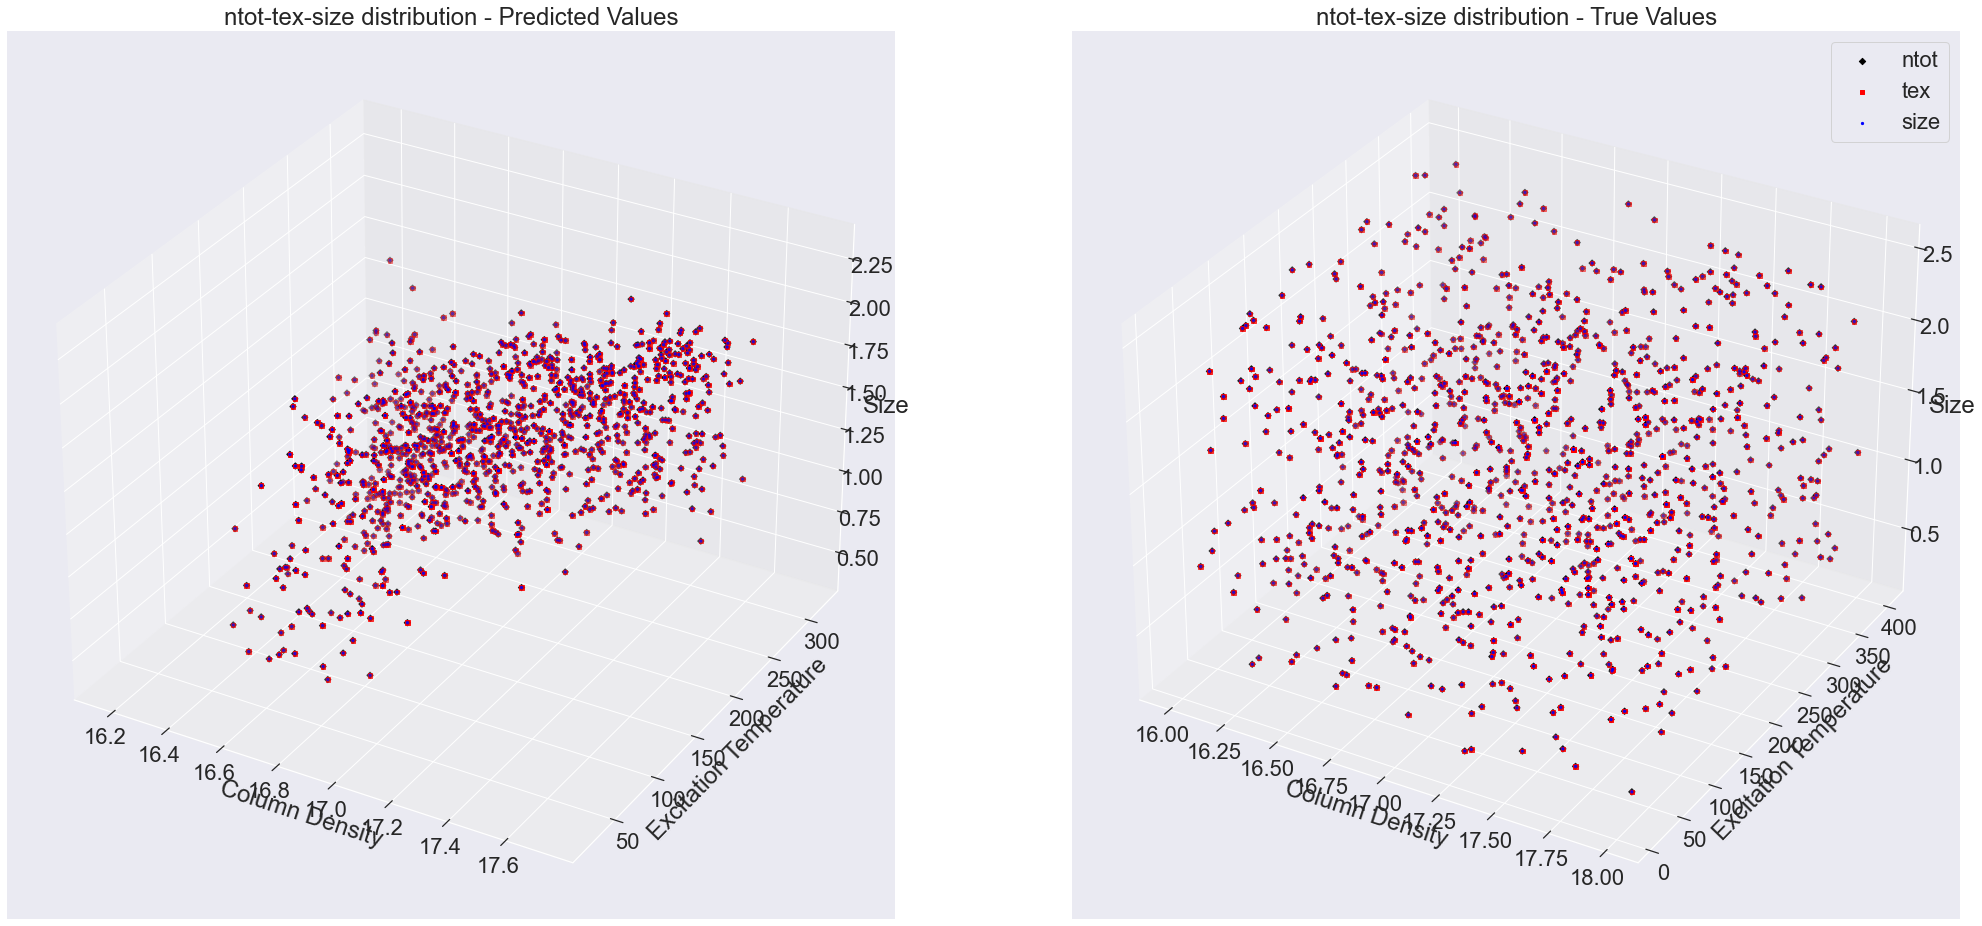

In [57]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    x1 = pred_param_rf['ntot']
    y1 = pred_param_rf['tex']
    z1 = pred_param_rf['size']
    
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density')
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig("data/5K_gen_files/scatter3D_pred_true_5K_RF_less.png")
plt.show()

All the points are taking up the same position in a 3D space. Not sure if this is how its supposed to be. From my understanding, the Column density is dependent on Temperature, so they take the `x`, and `y` positions while size takes the `z` position.plt

## Hyperparameter Tuning for Random Forest

In [ ]:
multirf_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        criterion="squared_error",
        bootstrap=True,
        n_jobs=-1,
        max_samples=None,
))

multrf_hyperparameters = dict(
    estimator__n_estimators=np.arange(100, 1000, 100),
    estimator__max_depth=np.arange(10, 150, 10),
    estimator__min_samples_split=np.arange(2, 10, 2),
    estimator__min_samples_leaf=np.arange(1, 5, 1),
    # estimator__min_weight_fraction_leaf=np.arange(0, 0.5, 0.1),
    # estimator__criterion=["squared_error", "absolute_error"],
    estimator__max_features=["auto", "sqrt", "log2"],
    # estimator__max_samples=np.arange(0.5, 1, 0.1),
    estimator__bootstrap=["True", "False"]
    )

In [ ]:
random_search = RandomizedSearchCV(
    estimator=multirf_model,
    param_distributions=multrf_hyperparameters,
    n_iter=100,
    cv=5,
    verbose=2,
    error_score="raise",
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

In [58]:
# best parameters from tuned model
regr_tuned_multirf = MultiOutputRegressor(
    estimator=RandomForestRegressor(
       n_estimators=800, 
       min_samples_split=2,
       min_samples_leaf=1,
       max_features='auto', 
       max_depth=130,
       bootstrap=True,
       verbose=5
    )
)

In [59]:
hyper_rf_tuned_model = regr_tuned_multirf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 800


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


building tree 2 of 800


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


building tree 3 of 800


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s


building tree 4 of 800


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.1s remaining:    0.0s


building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 8

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 24.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 800


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


building tree 2 of 800


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.1s remaining:    0.0s


building tree 3 of 800


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.2s remaining:    0.0s


building tree 4 of 800


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.5s remaining:    0.0s


building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 8

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 67.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 800


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


building tree 2 of 800


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s


building tree 3 of 800


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.9s remaining:    0.0s


building tree 4 of 800


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.8s remaining:    0.0s


building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 8

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 42.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 800


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


building tree 2 of 800


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


building tree 3 of 800


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.9s remaining:    0.0s


building tree 4 of 800


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.9s remaining:    0.0s


building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 8

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 27.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 800


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


building tree 2 of 800


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


building tree 3 of 800


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s


building tree 4 of 800


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.8s remaining:    0.0s


building tree 5 of 800
building tree 6 of 800
building tree 7 of 800
building tree 8 of 800
building tree 9 of 800
building tree 10 of 800
building tree 11 of 800
building tree 12 of 800
building tree 13 of 800
building tree 14 of 800
building tree 15 of 800
building tree 16 of 800
building tree 17 of 800
building tree 18 of 800
building tree 19 of 800
building tree 20 of 800
building tree 21 of 800
building tree 22 of 800
building tree 23 of 800
building tree 24 of 800
building tree 25 of 800
building tree 26 of 800
building tree 27 of 800
building tree 28 of 800
building tree 29 of 800
building tree 30 of 800
building tree 31 of 800
building tree 32 of 800
building tree 33 of 800
building tree 34 of 800
building tree 35 of 800
building tree 36 of 800
building tree 37 of 800
building tree 38 of 800
building tree 39 of 800
building tree 40 of 800
building tree 41 of 800
building tree 42 of 800
building tree 43 of 800
building tree 44 of 800
building tree 45 of 800
building tree 46 of 8

[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 15.8min finished


In [60]:
y_multirf_tuned_rf = hyper_rf_tuned_model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

In [ ]:
# print("Best hyperparameters: ", hyper_rf_tuned_model.best_params_)
# print("Best score: ", hyper_rf_tuned_model.best_score_)

Best hyperparameters:  {'estimator__n_estimators': 800, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_features': 'auto', 'estimator__max_depth': 130, 'estimator__bootstrap': 'True'}
Best score:  0.6780101270617723

In [ ]:
# tuned_rf_model = hyper_rf_tuned_model.best_estimator_
# y_multrf_tuned_tf = tuned_rf_model.predict(X_test)

In [61]:
# # TODO: interpret the model evaluation metrics
eval = RegressionMetrics()
for metric in _metrics:
    print(metric, ":", eval.get_metric(metric, y_test, y_multirf_tuned_rf))

mae : 9.672627141794736
mse : 717.5140185743397
rmse : 26.786452146081977
mape : fwhm     8.725733
ntot     1.723232
size    32.790099
tex     36.765995
vlsr     9.758639
dtype: float64
r2 : 0.7759518281218016
msle : 26.786452146081977


### True vs Predicted Values - RF Tuned Model

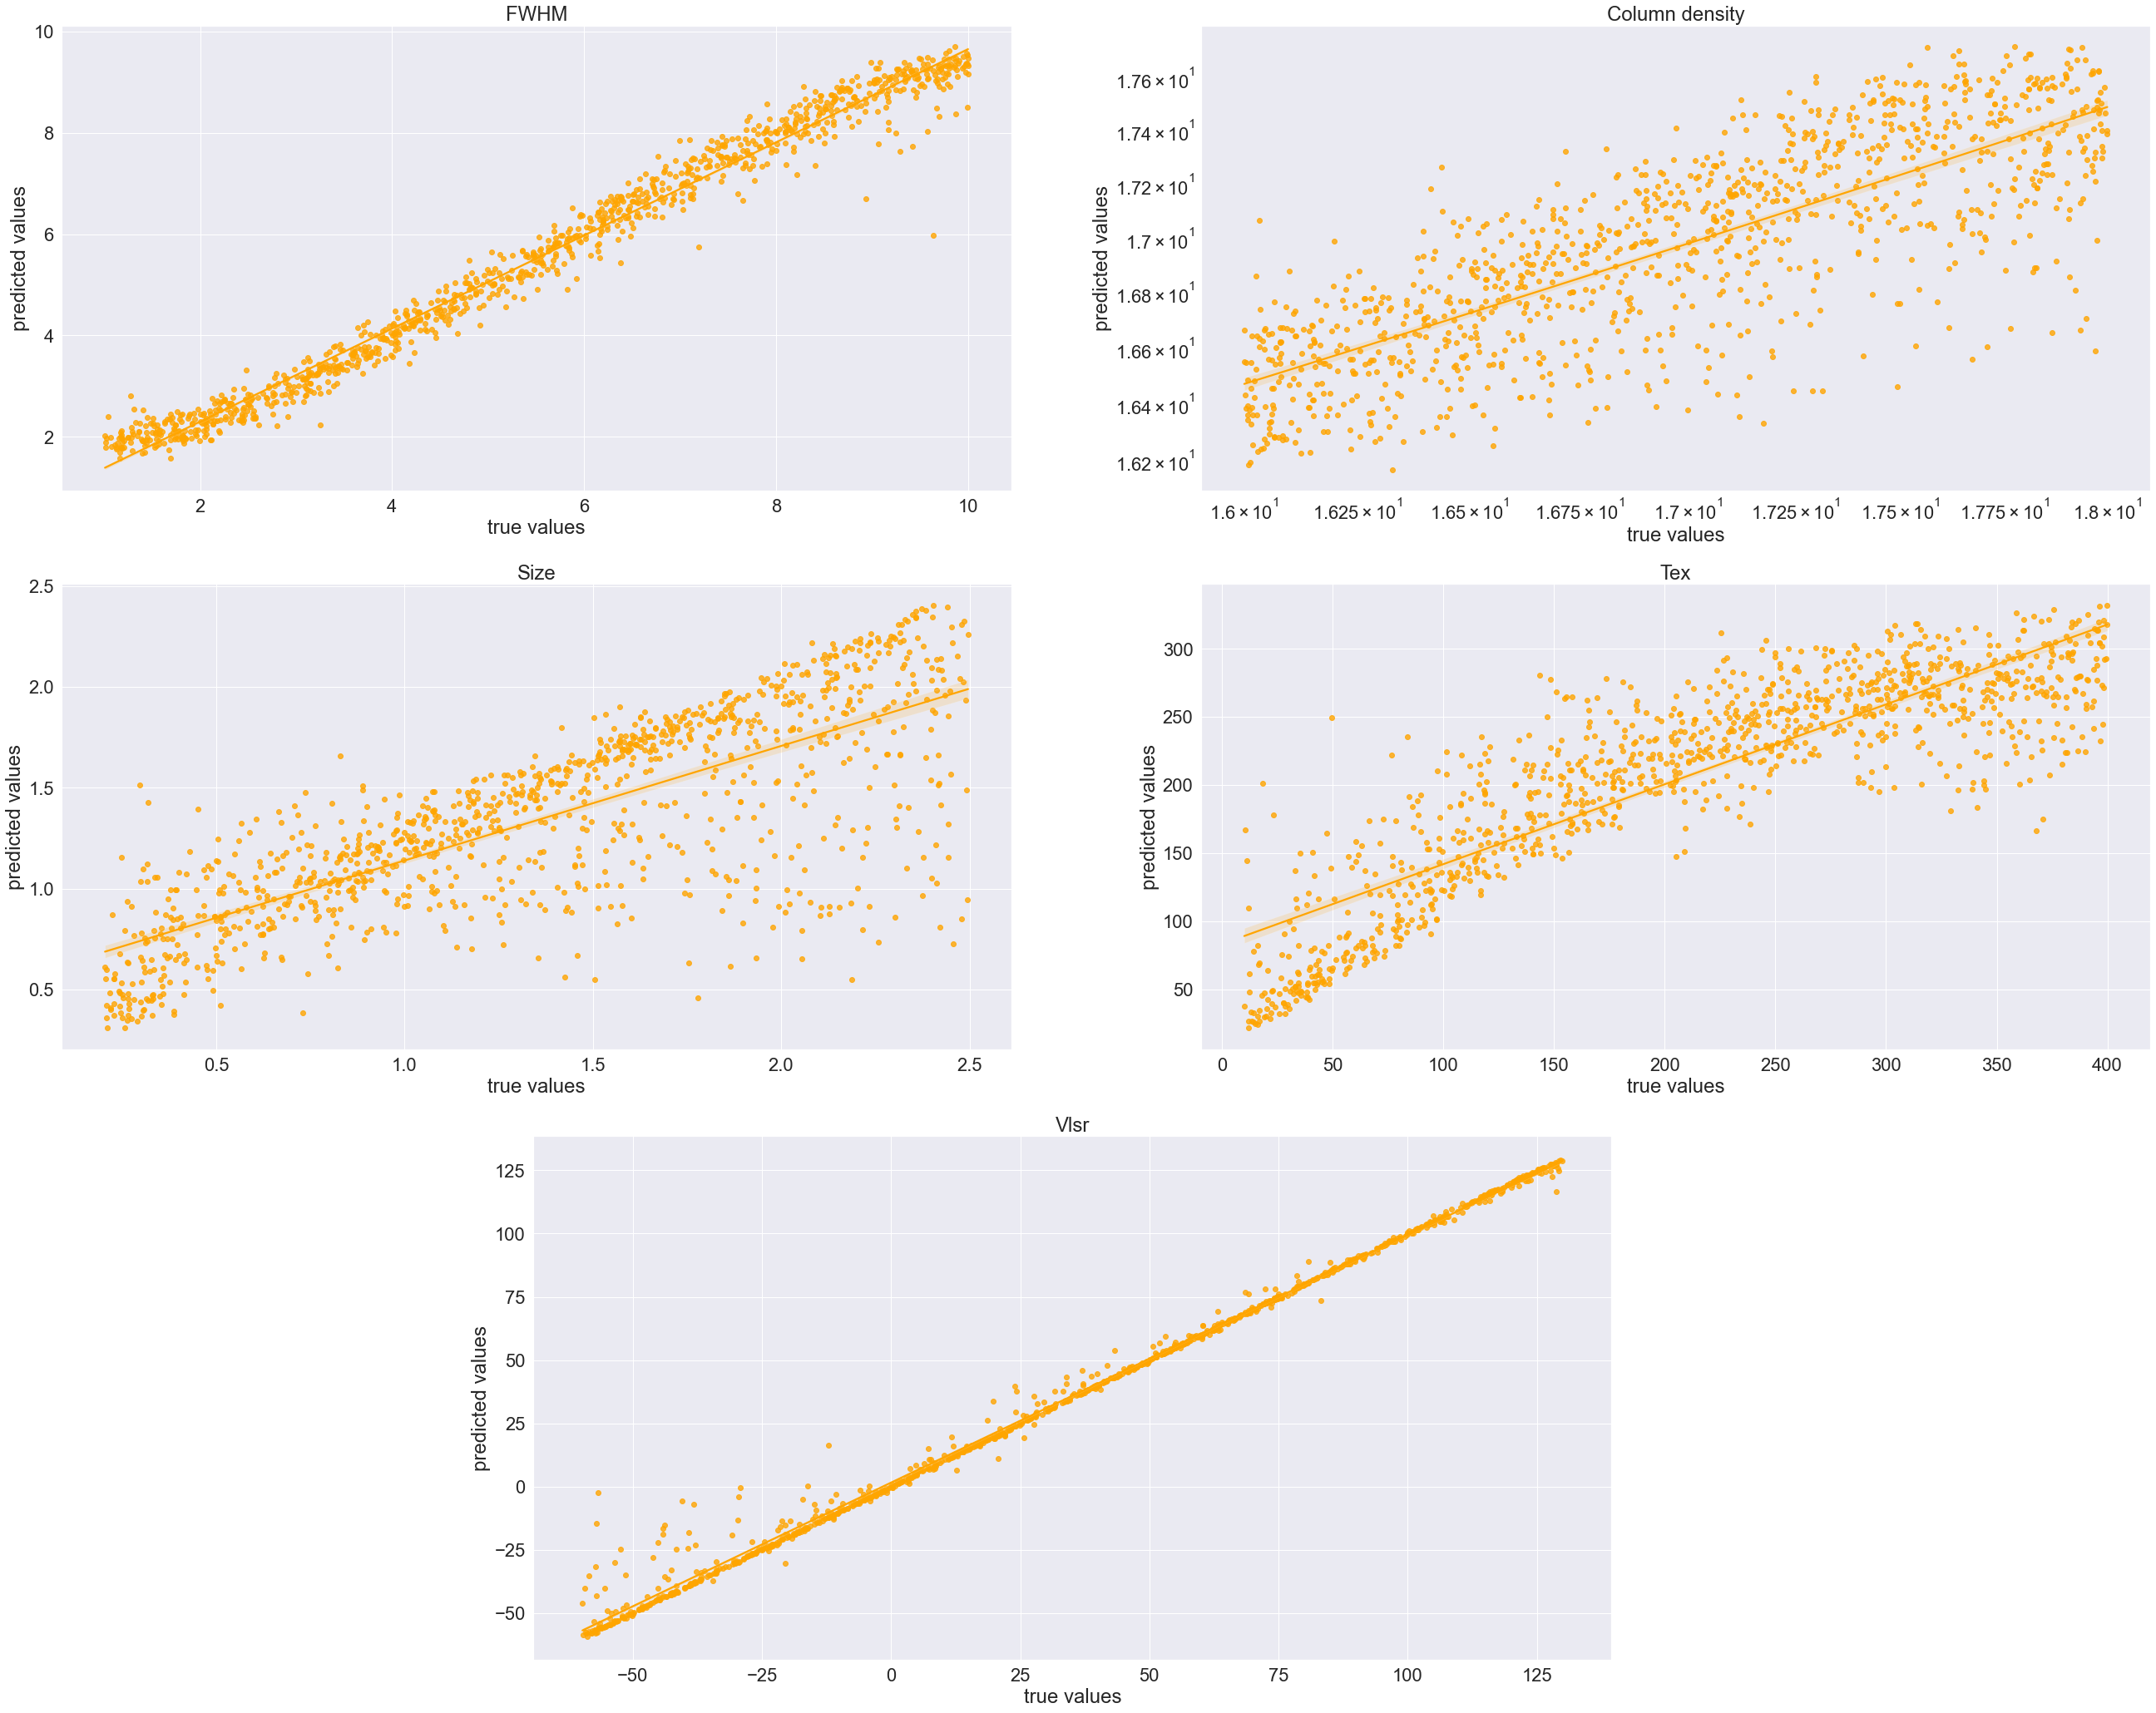

In [63]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:,0], y=y_multirf_tuned_rf[:,0], color='orange', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multirf_tuned_rf[:,1], color='orange', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multirf_tuned_rf[:,2], color='orange', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multirf_tuned_rf[:,3], color='orange', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multirf_tuned_rf[:,4], color='orange', ax=axes[2,0]) # vlsr

g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", xscale='log', yscale='log')
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/5K_gen_files/pred_true_5K_tuned_RF_less.png")
plt.show()

### Residuals - RF Tuned Model

In [64]:
residuals_tuned_rf = (y_test - y_multirf_tuned_rf)
residuals_tuned_rf

fwhm      ntot      size         tex      vlsr
2573 -0.027968  0.583964 -0.065831  -10.632664  0.055040
2574  0.103302 -0.072519  0.236474   20.190905 -0.116418
2575  0.398866 -0.320472  1.235012   -4.807510  0.719167
2576 -0.167114  0.067447  0.081073  104.925959  0.220430
2577  0.048381 -0.380885  0.060201  -22.046562  0.070104
...        ...       ...       ...         ...       ...
3672 -0.029559  0.344641 -0.481069   88.407255 -0.234649
3673  0.298301 -0.201455  0.046584  -36.614462  0.988618
3674  0.267283  0.195515 -0.016256  -56.352311  2.175541
3675  0.276138 -0.273485  0.486510   73.272899  0.049290
3676 -0.096080 -0.460454  0.460644  -17.829108  0.469477

[1104 rows x 5 columns]

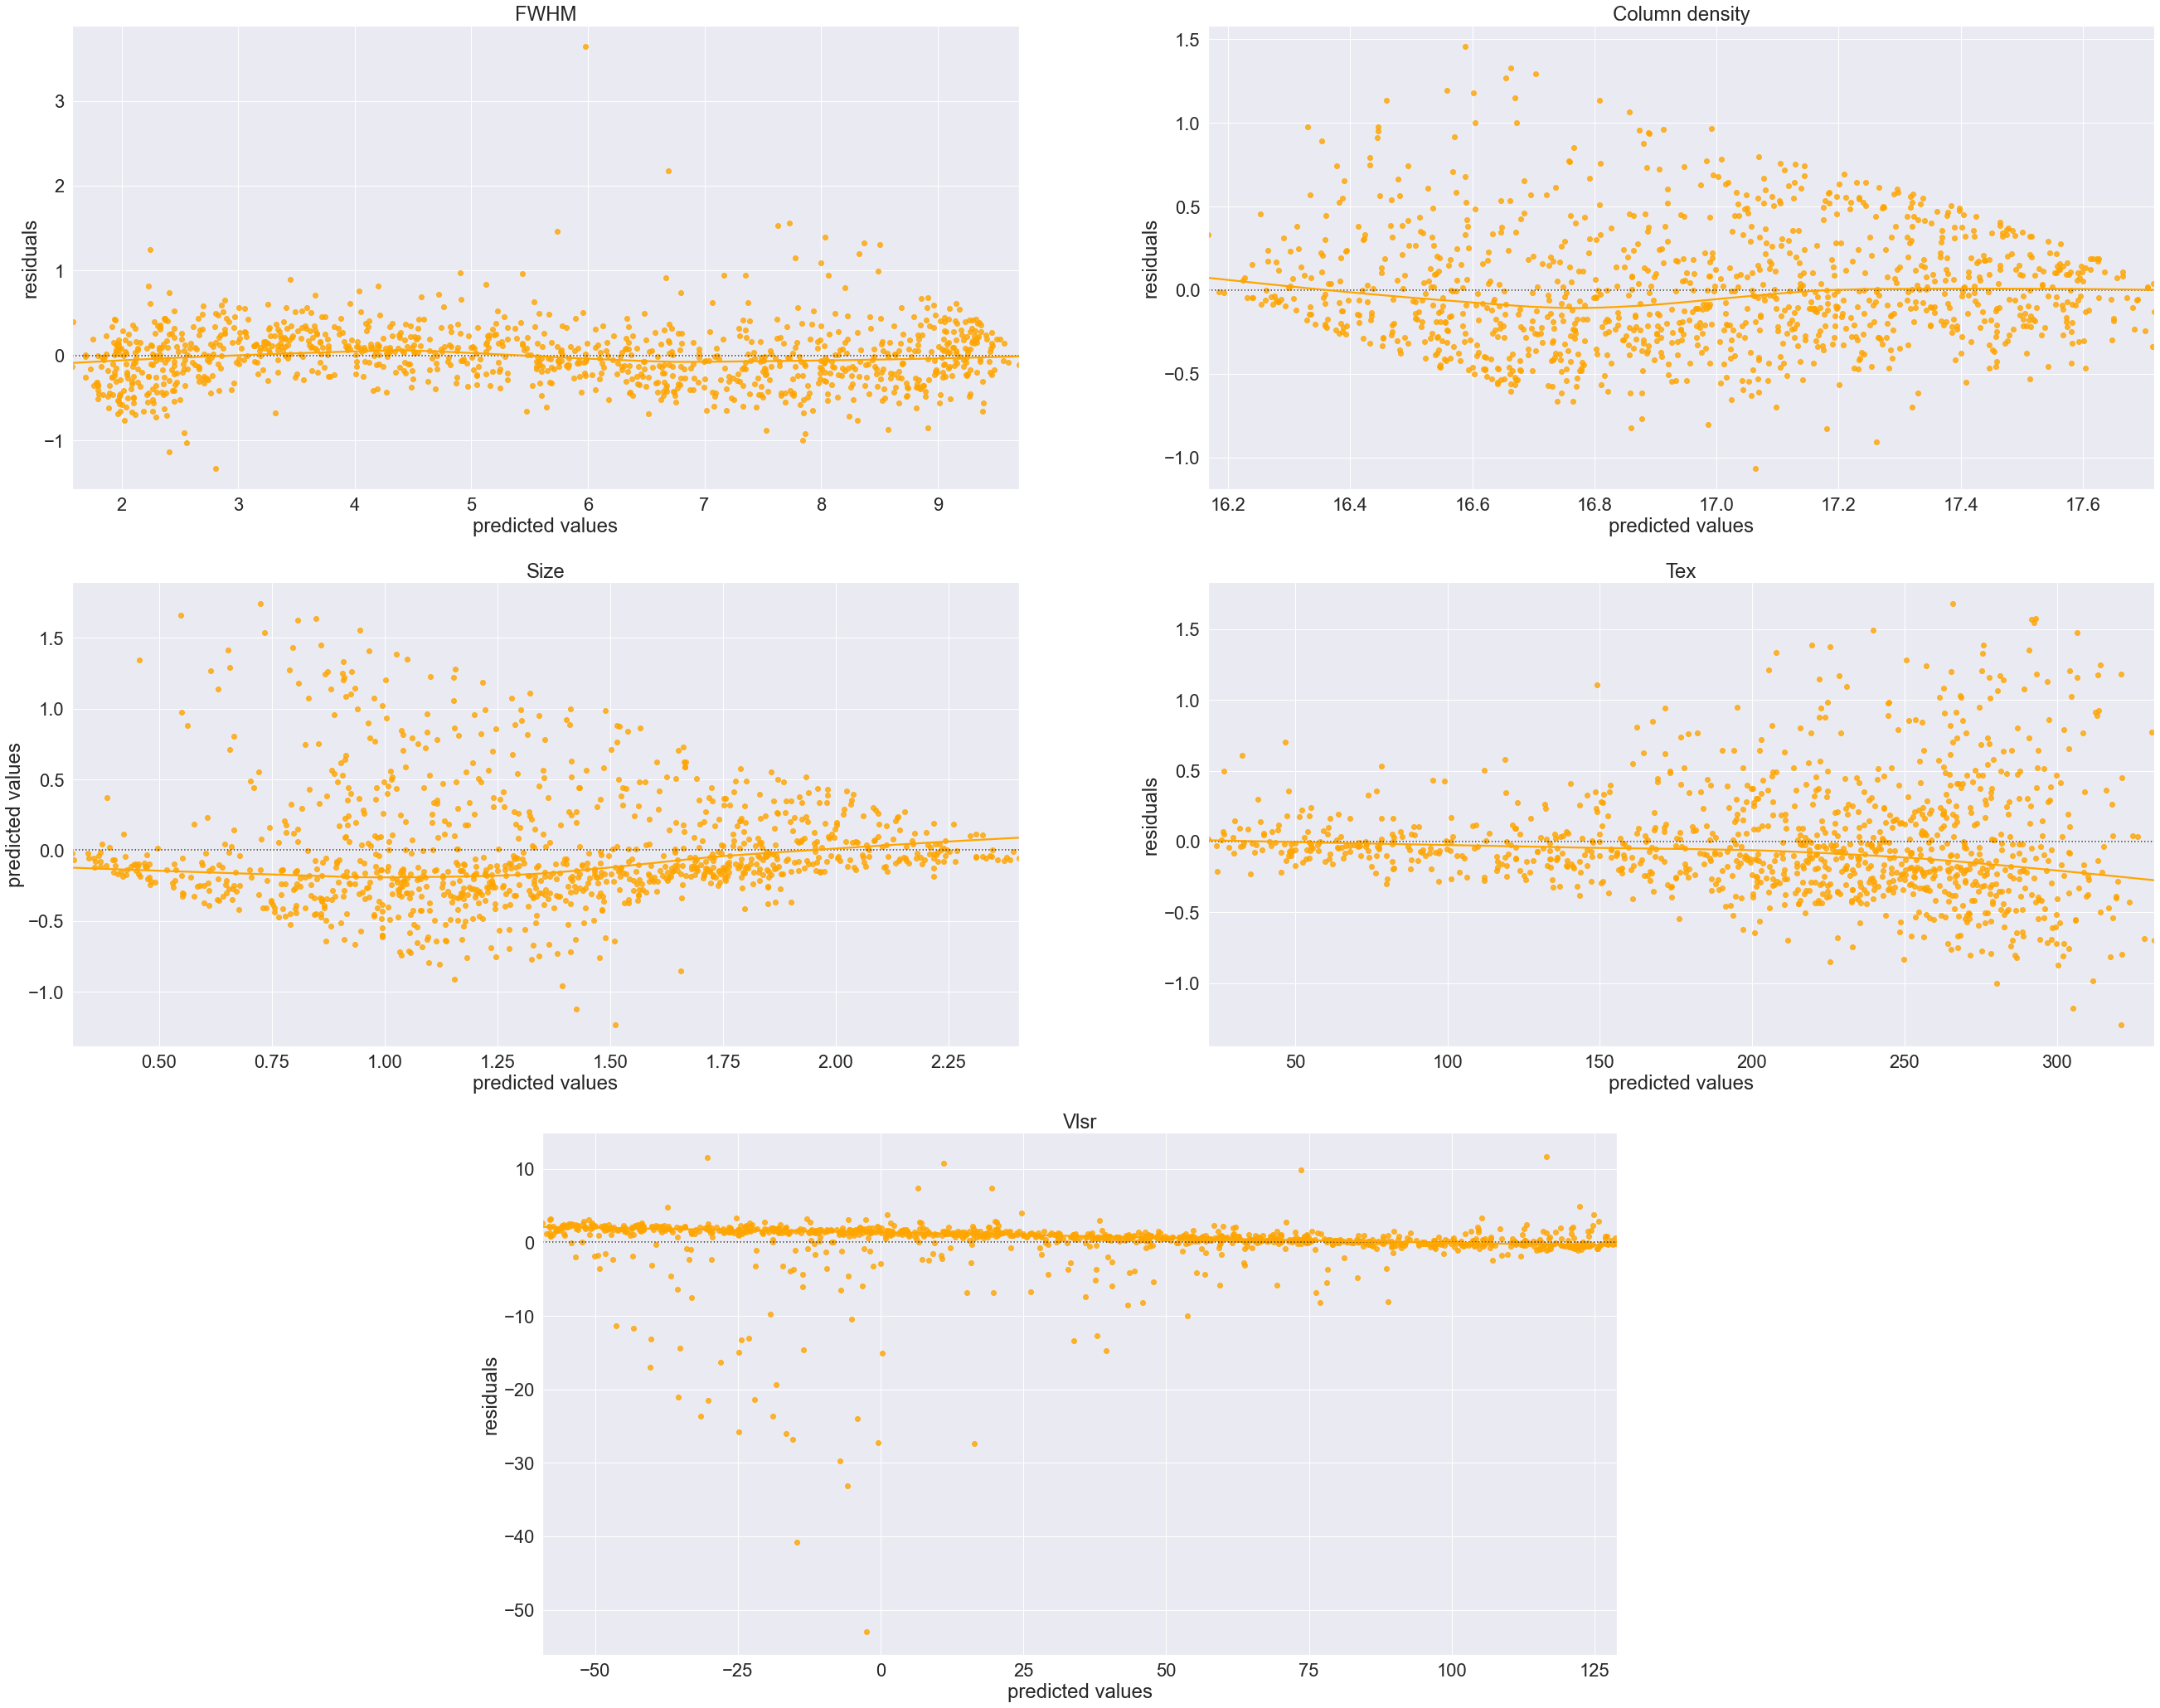

In [65]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multirf_tuned_rf[:,0], y=residuals_tuned_rf['fwhm'], lowess=True, ax=axes[0,0], color='orange') # fwhm
g2 = sns.residplot(x=y_multirf_tuned_rf[:,1], y=residuals_tuned_rf['ntot'], lowess=True, ax=axes[0,1], color='orange') # column density
g3 = sns.residplot(x=y_multirf_tuned_rf[:,2], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,0], color='orange') # size
g4 = sns.residplot(x=y_multirf_tuned_rf[:,3], y=residuals_tuned_rf['size'], lowess=True, ax=axes[1,1], color='orange') # tex
g5 = sns.residplot(x=y_multirf_tuned_rf[:,4], y=residuals_tuned_rf['vlsr'], lowess=True, ax=axes[2,0], color='orange') # vlsr
g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/5K_gen_files/residuals_tuned_RF_5K_less.png")
plt.show()

## 2. XGBoost Regressor

In [66]:
multixgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        n_estimators=100,
        max_depth=10,
        max_leaves=10,
        max_bin=10,
        learning_rate=0.1,
        n_jobs=-1,
        gamma=0,
        min_child_weight=1.0,
        max_delta_step=0,
        importance_type="gain",
        eval_metric=metrics.mean_squared_error
    )
)

multixgb_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            eval_metric=<function mean_squared_error at 0x7ffd10c22550>,
                                            gamma=0, gpu_id=None,
                                            importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=10,
                                            max_delta_step=0, max_depth=10,
                                            max_leaves=10, min_child_weight=1.0,
                                            missing=nan,
                                            monoton

In [67]:
y_multixgb_pred = multixgb_model.predict(X_test)

In [68]:
for metric in _metrics:
    print(metric, ":", metrics_multirf.get_metric(metric, y_test, y_multixgb_pred))

mae : 9.923703906891092
mse : 759.6432191489935
rmse : 27.561625843715994
mape : fwhm     6.249400
ntot     1.845830
size    39.627351
tex     35.384272
vlsr    43.847316
dtype: float64
r2 : 0.741663925875325
msle : 27.561625843715994


### save the predicted parameters to a csv file

In [71]:
param_df_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm_pred_xgb', 'ntot_pred_xgb', 'size_pred_xgb', 'tex_pred_xgb', 'vlsr_xgb_pred'])
param_df_xgb['ntot_pred_xgb'] = np.exp(param_df_xgb['ntot_pred_xgb'])
param_df_xgb.to_csv('data/5K_gen_files/predicted_parameters_xgb_less.csv')

In [72]:
param_df_xgb.head()

fwhm_pred_xgb  ntot_pred_xgb  size_pred_xgb  tex_pred_xgb  vlsr_xgb_pred
0       5.857234     20979382.0       1.851030     14.944442      68.376221
1       2.586361     28409910.0       1.885172    254.824249     -52.262199
2       9.487539     16633580.0       0.720669    291.921906     105.043228
3       8.514096     45126188.0       2.126205    324.069183      66.711540
4       6.453935     24816696.0       1.674745    164.955063      13.892434

### Predicted vs True values - XGB Regressor

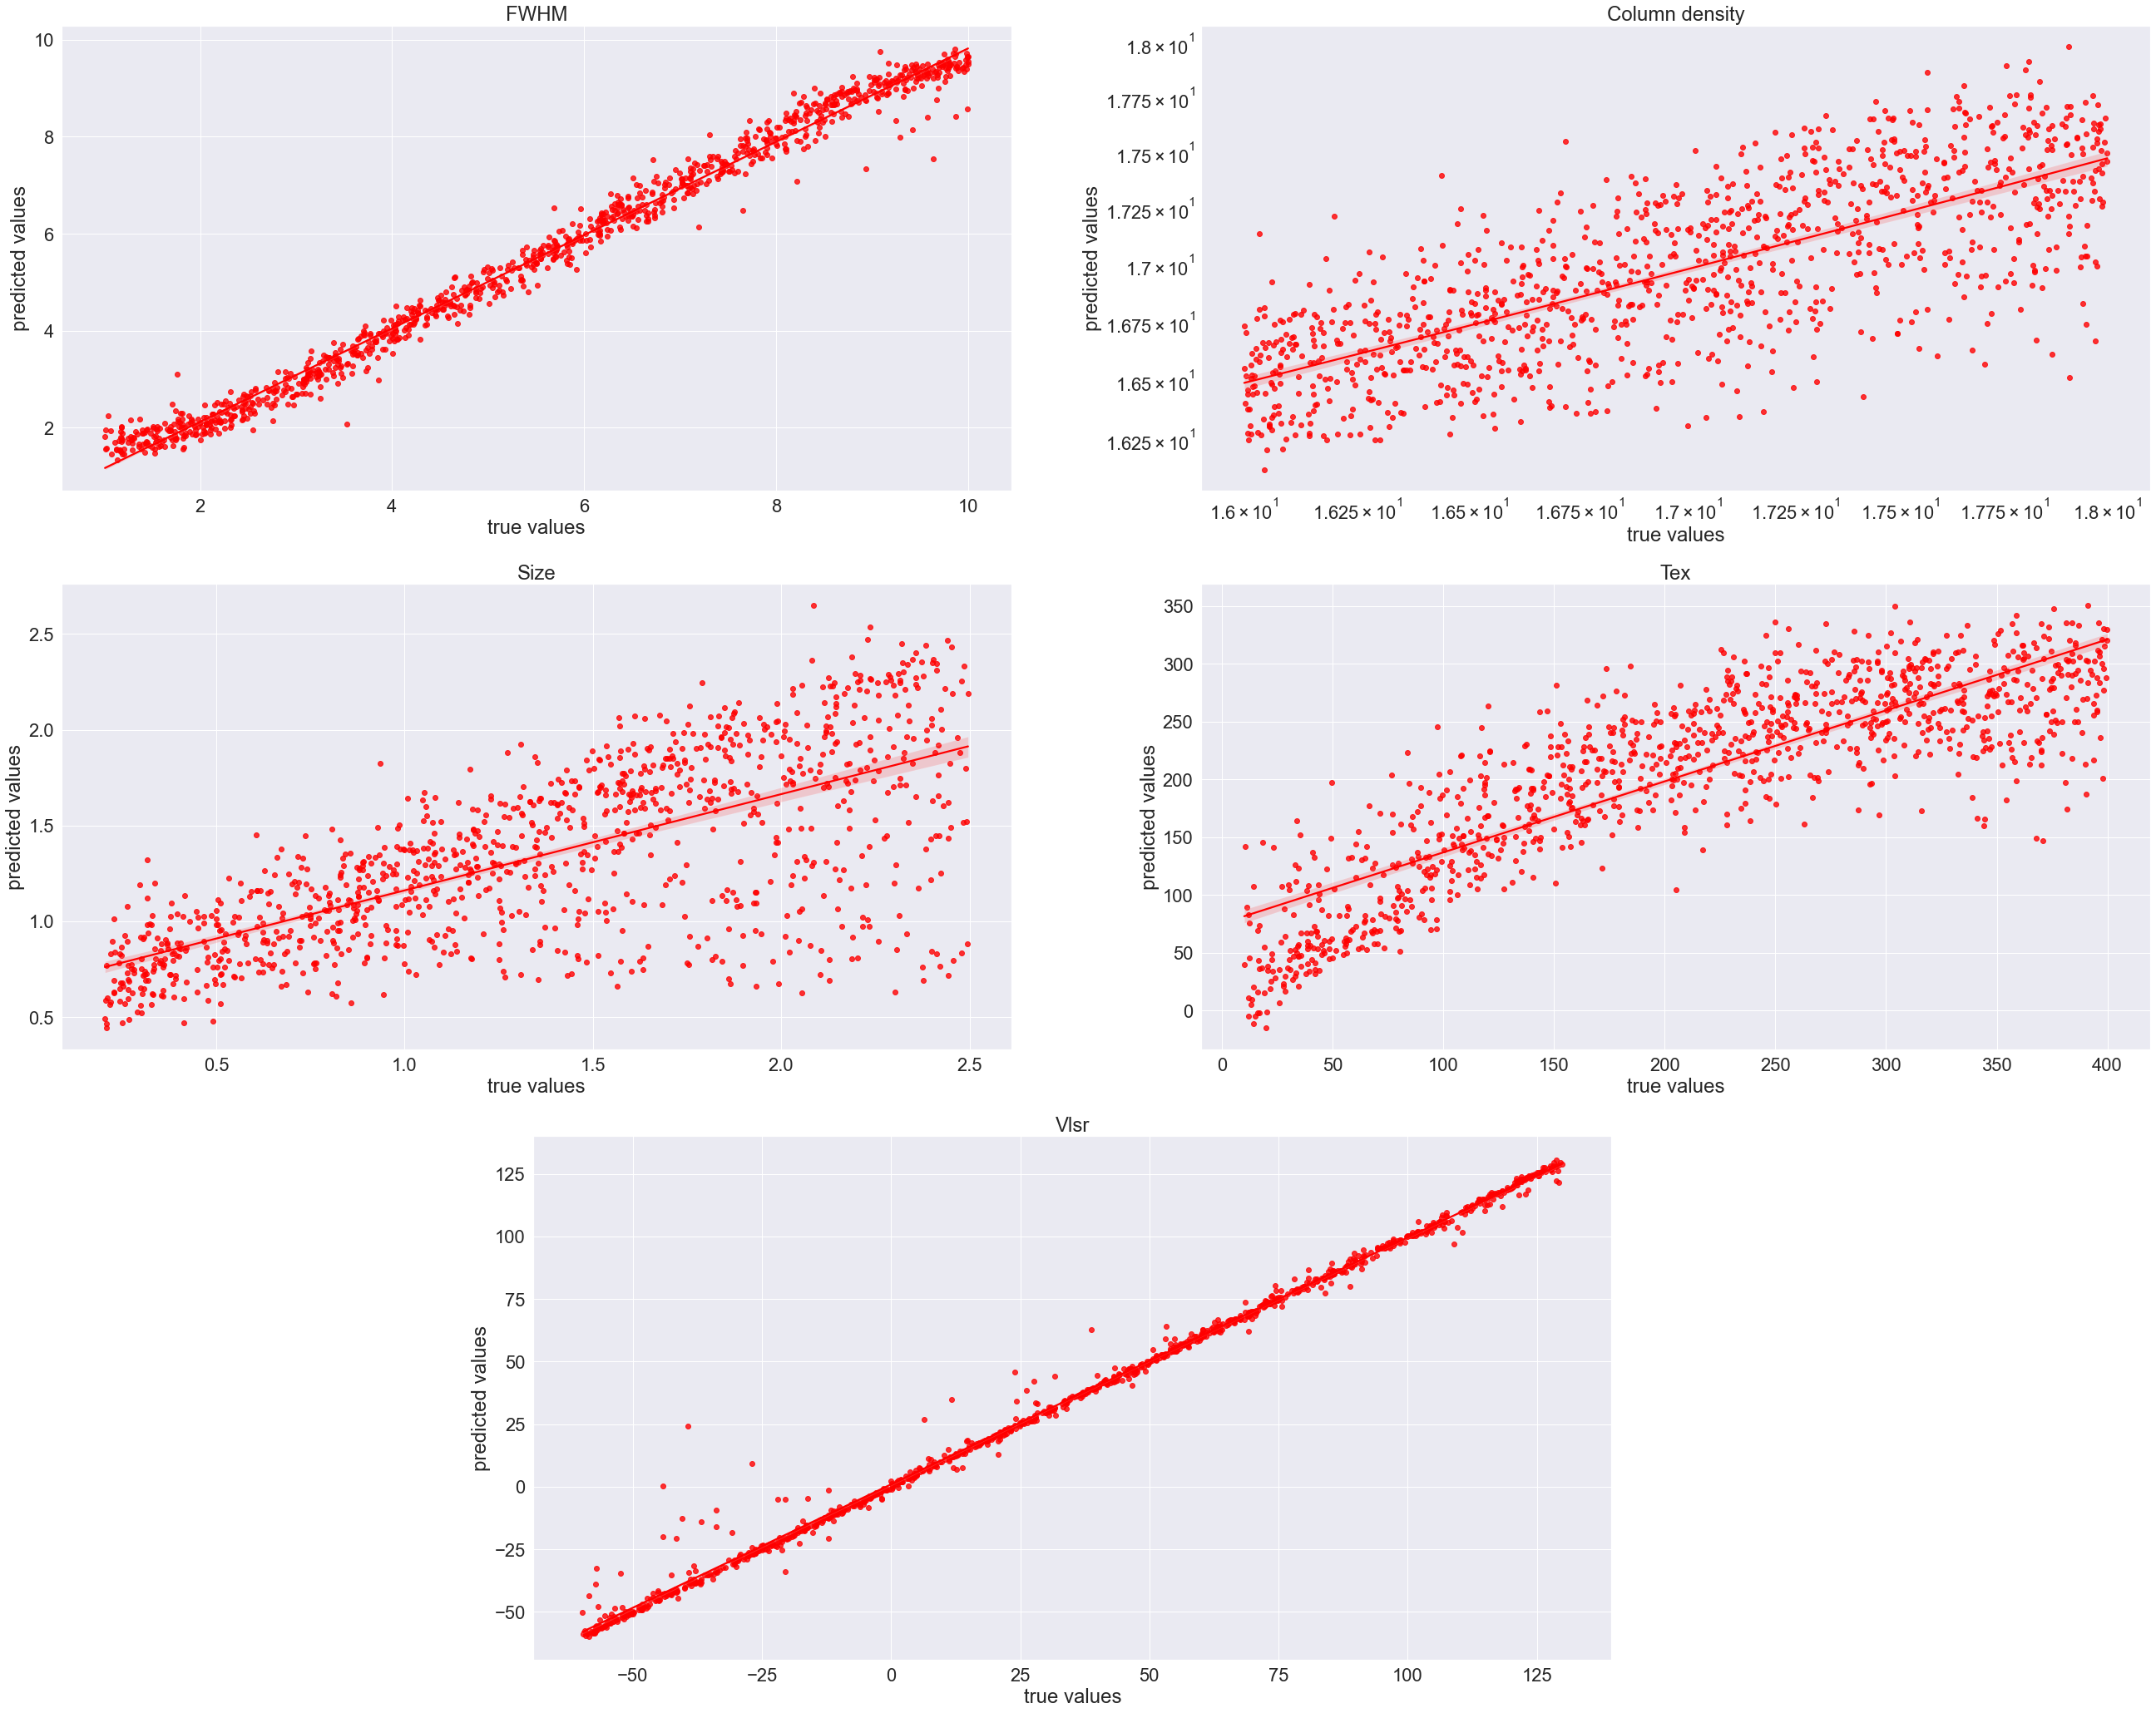

In [75]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

g1 = sns.regplot(x=y_test.iloc[:, 0], y=y_multixgb_pred[:,0],color='red', ax=axes[0,0]) # fwhm
g2 = sns.regplot(x=y_test.iloc[:,1], y=y_multixgb_pred[:,1], color='red', ax=axes[0,1]) # column density
g3 = sns.regplot(x=y_test.iloc[:,2], y=y_multixgb_pred[:,2], color='red', ax=axes[1,0]) # size
g4 = sns.regplot(x=y_test.iloc[:,3], y=y_multixgb_pred[:,3], color='red', ax=axes[1,1]) # tex
g5 = sns.regplot(x=y_test.iloc[:,4], y=y_multixgb_pred[:,4], color='red', ax=axes[2,0]) # vlsr
g1.set(title='FWHM', ylabel="predicted values", xlabel="true values")
g2.set(title='Column density', ylabel="predicted values", xlabel="true values", yscale="log", xscale="log")
g3.set(title='Size', ylabel="predicted values", xlabel="true values")
g4.set(title='Tex', ylabel="predicted values", xlabel="true values")
g5.set(title='Vlsr', ylabel="predicted values", xlabel="true values")

plt.savefig("data/5K_gen_files/pred_true_5K_XGB_less.png")
plt.show()

### 3D plots - Columnn density, Excitation temperature and Size - XGB Regressor

In [74]:
pred_param_xgb = pd.DataFrame(y_multixgb_pred, columns=['fwhm', 'ntot', 'size', 'tex', 'vlsr'])
pred_param_xgb.head()

fwhm       ntot      size         tex        vlsr
0  5.857234  16.859051  1.851030   14.944442   68.376221
1  2.586361  17.162249  1.885172  254.824249  -52.262199
2  9.487539  16.626934  0.720669  291.921906  105.043228
3  8.514096  17.624973  2.126205  324.069183   66.711540
4  6.453935  17.027027  1.674745  164.955063   13.892434

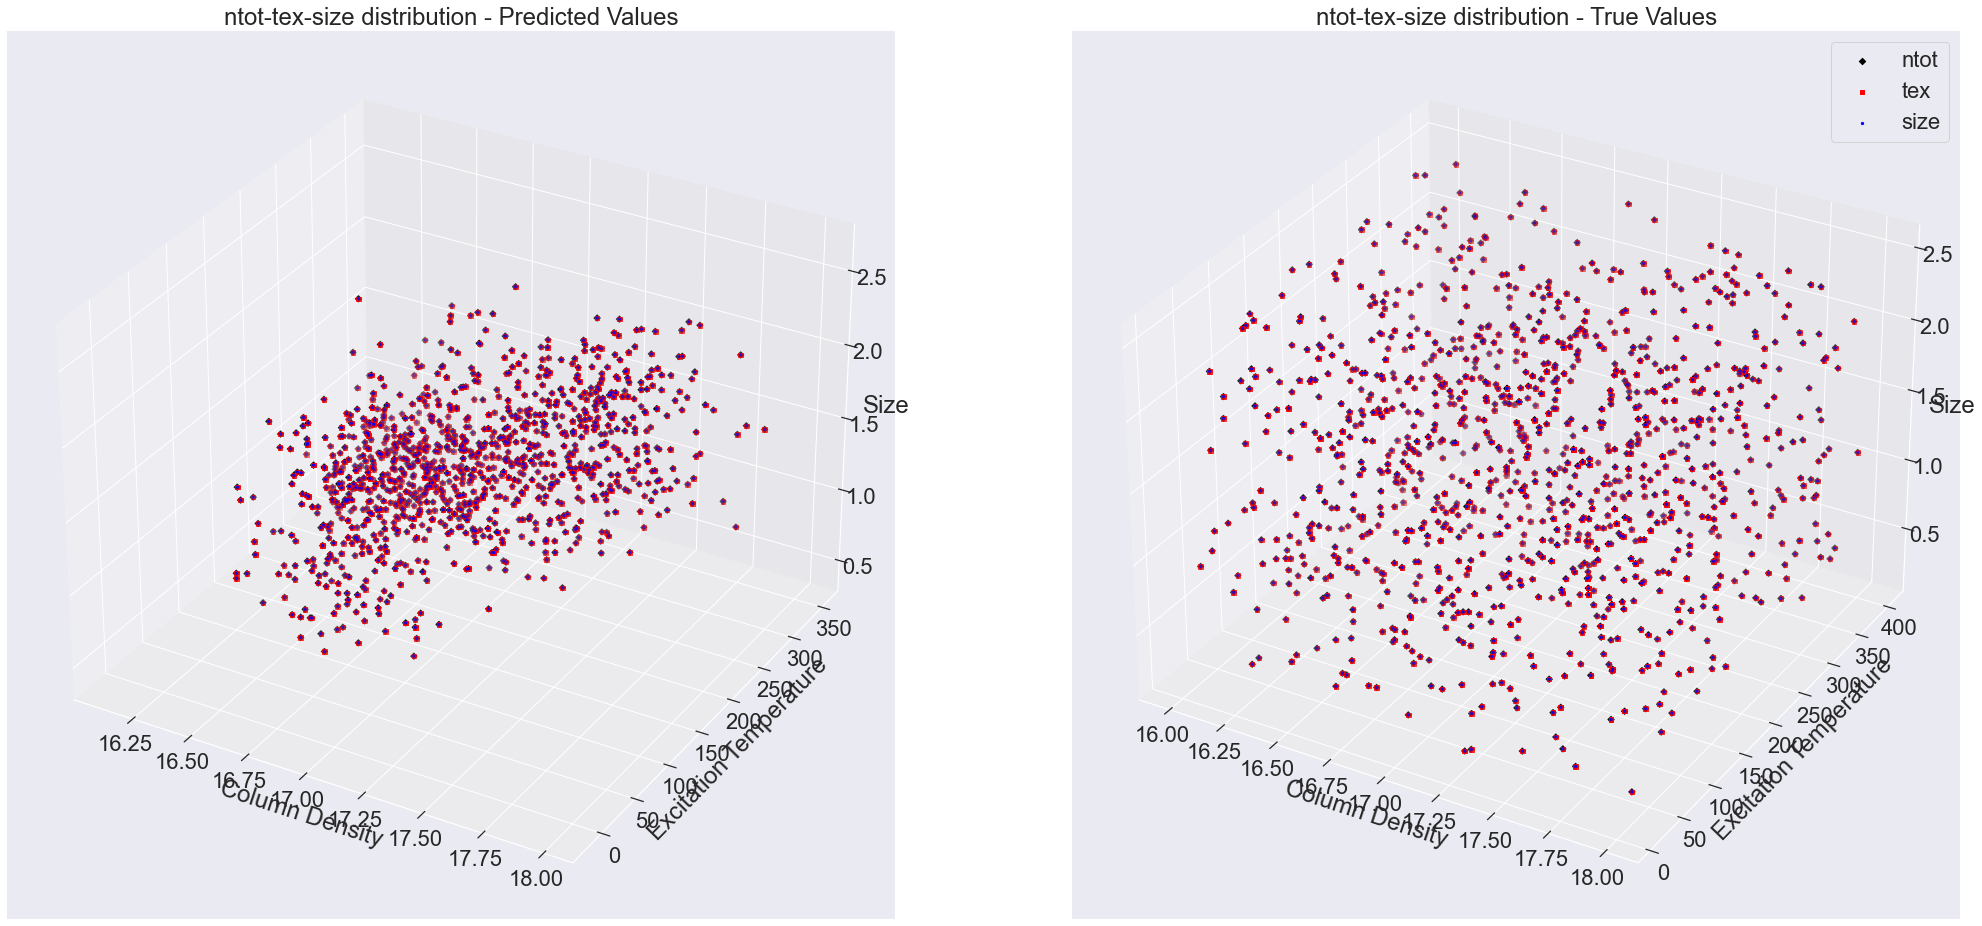

In [76]:
fig = plt.figure(figsize=(35, 25))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')


markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']


x1 = pred_param_xgb['ntot']
y1 = pred_param_xgb['tex']
z1 = pred_param_xgb['size']
    
x2 = y_test['ntot']
y2 = y_test['tex']
z2 = y_test['size']


for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])
    ax2.scatter3D(x2, y2, z2, marker=markers[i], color=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Predicted Values')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')


ax2.set_title('ntot-tex-size distribution - True Values')
ax2.set_xlabel('Column Density', )
ax2.set_ylabel('Excitation Temperature')
ax2.set_zlabel('Size')
plt.legend(loc="best")

plt.savefig("data/5K_gen_files/scatter3D_pred_true_5K_XGB_less.png")
plt.show()

### Residuals 3D plot - XGB Regressor

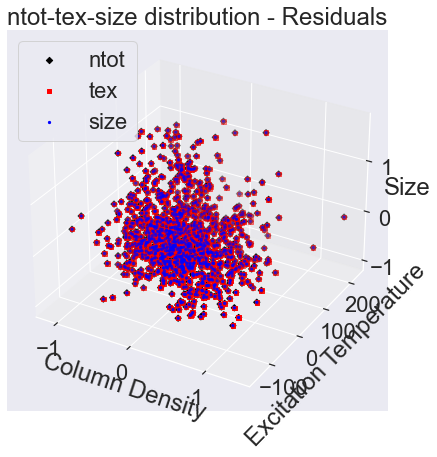

In [77]:
fig = plt.figure(figsize=(15, 7))
plt.setp(ax.get_xticklabels(), fontsize=14)
ax1 = fig.add_subplot(121, projection='3d')

markers = ['D', 's', '.']
labels = ['ntot', 'tex', 'size']
colors = ['black', 'red', 'blue']

residuals_xgb = (y_test - y_multixgb_pred)
# residuals
x1 = residuals_xgb['ntot']
y1 = residuals_xgb['tex']
z1 = residuals_xgb['size']

for i in range(len(markers)):
    ax1.scatter3D(x1, y1, z1, marker=markers[i], c=colors[i], label=labels[i])

ax1.set_title('ntot-tex-size distribution - Residuals')
ax1.set_xlabel('Column Density')
ax1.set_ylabel('Excitation Temperature')
ax1.set_zlabel('Size')
plt.legend(loc="best")
plt.show()

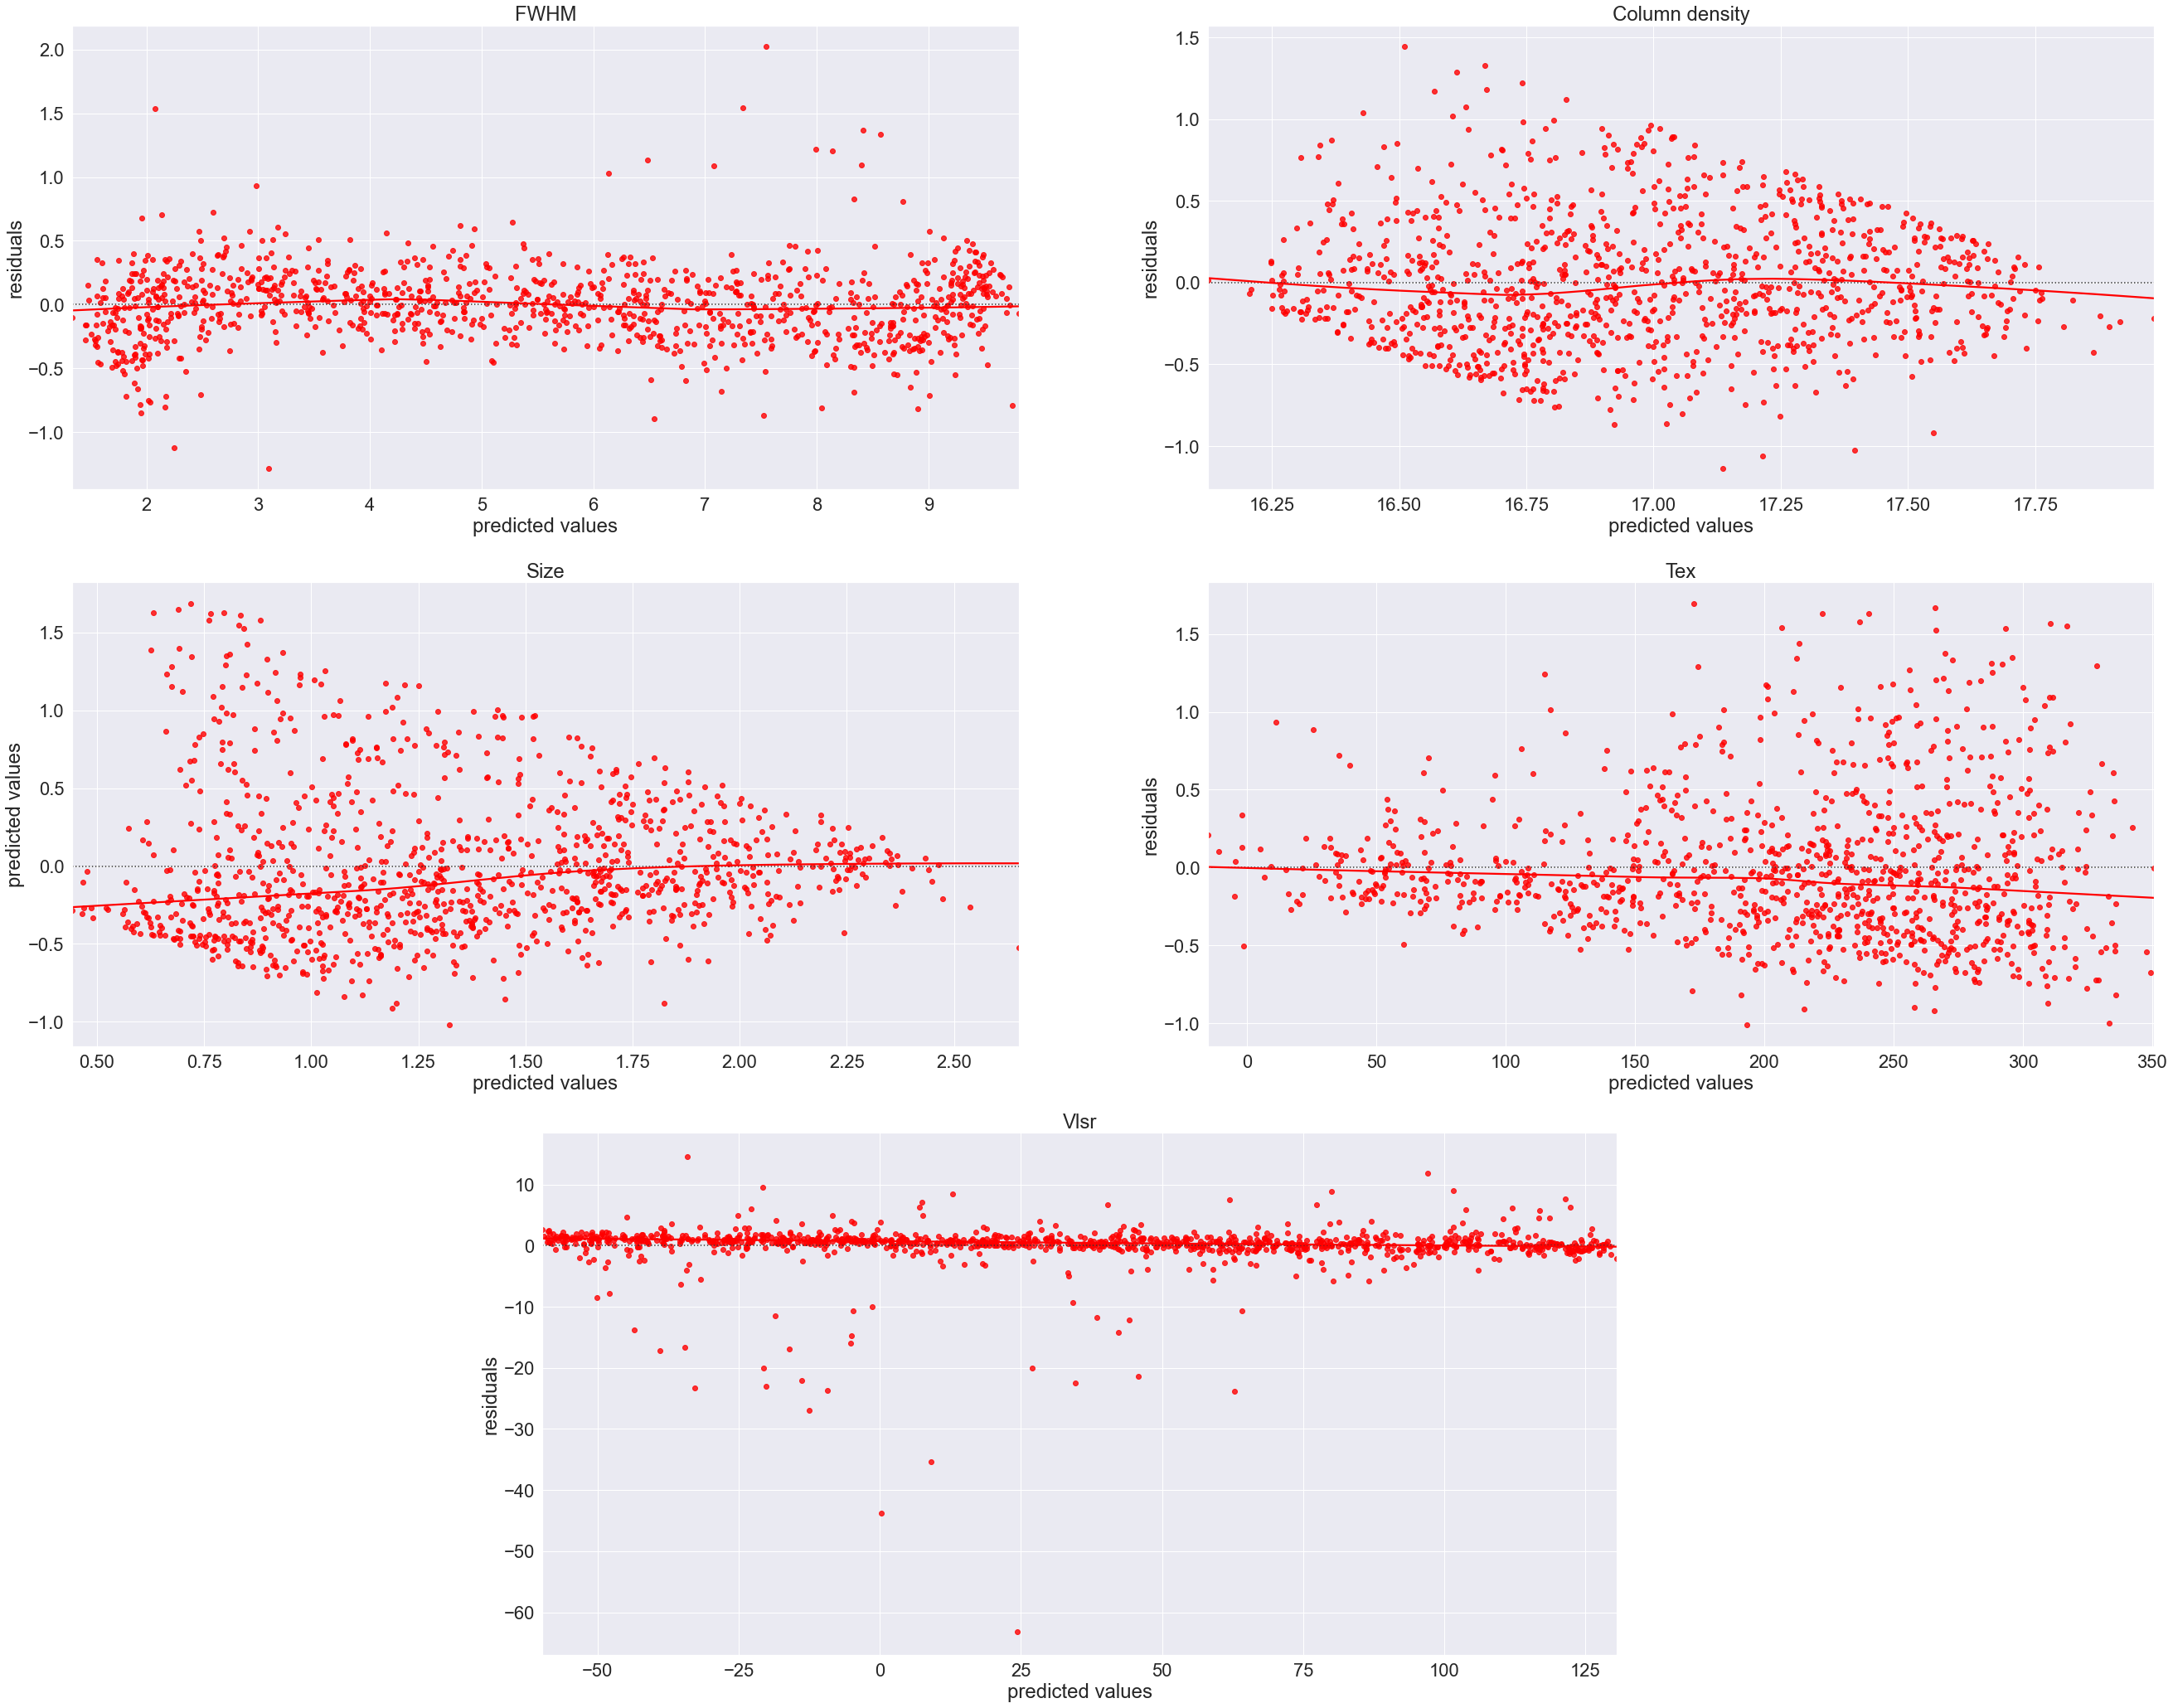

In [78]:
fig, axes = plt.subplots(3, 2, figsize=(45,35))
plt.setp(ax.get_xticklabels(), fontsize=14)
sns.set_theme(font_scale=2) 
axes[2,1].set_visible(False)
axes[2,0].set_position([0.30, 0.1,0.40,0.25])

# plot the redisual distribution using seaborn
g1 = sns.residplot(x=y_multixgb_pred[:,0], y=residuals_xgb['fwhm'], lowess=True, ax=axes[0,0], color='red') # fwhm
g2 = sns.residplot(x=y_multixgb_pred[:,1], y=residuals_xgb['ntot'], lowess=True, ax=axes[0,1], color='red') # column density
g3 = sns.residplot(x=y_multixgb_pred[:,2], y=residuals_xgb['size'], lowess=True, ax=axes[1,0], color='red') # size
g4 = sns.residplot(x=y_multixgb_pred[:,3], y=residuals_xgb['size'], lowess=True, ax=axes[1,1], color='red') # tex
g5 = sns.residplot(x=y_multixgb_pred[:,4], y=residuals_xgb['vlsr'], lowess=True, ax=axes[2,0], color='red') # vlsr

g1.set(title='FWHM', ylabel="residuals", xlabel="predicted values")
g2.set(title='Column density', ylabel="residuals", xlabel="predicted values")
g3.set(title='Size', ylabel="predicted values", xlabel="predicted values")
g4.set(title='Tex', ylabel="residuals", xlabel="predicted values")
g5.set(title='Vlsr', ylabel="residuals", xlabel="predicted values")

plt.savefig("data/5K_gen_files/residuals_XGB_5K_less.png")
plt.show()